In [169]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from gap_statistic import OptimalK
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

# importing bokeh library for interactive dataviz
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

import os
from nltk.parse import stanford
from nltk.tokenize.stanford_segmenter import StanfordSegmenter
os.environ['CLASSPATH'] = r"""libs\\stanford-parser-full-2014-08-27\\jars\\stanford-parser.jar:
libs\\stanford-parser-full-2014-08-27\\jars\\stanford-parser-3.4.1-models.jar:
libs\stanford-segmenter-2017-06-09\\stanford-segmenter-3.8.0.jar"""
os.environ['STANFORD_PARSER'] = 'libs\\stanford-parser-full-2014-08-27\\jars'
os.environ['STANFORD_MODELS'] = """libs\\stanford-parser-full-2014-08-27\\models"""
os.environ['STANFORD_SEGMENTER'] = "libs\\stanford-segmenter-2017-06-09"
# os.environ['JAVAHOME'] = r"C:\Program Files\Java\jdk1.8.0_25"

def deNoise(text):
    from string import punctuation
    noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ   |  # Tatwil/Kashida
                             ، 
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)
    text = ''.join(c for c in text if c not in punctuation)
    return text

def normalizeArabic(text):
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = ''.join([i for i in text if not i.isdigit()])
    text = re.sub(' +',' ',text)
    return(text)

stopWordsList = []
def reshapeStopWords():
    with codecs.open('stopWords.txt','r',encoding='utf8') as f:
        content = f.readlines()
        contentSet = list(set(content))
        for item in contentSet:
            item = item.strip()
#             item = deNoise(item)
            stopWordsList.append(item)
    
    return stopWordsList
def removeStopWords(text):
     return ' '.join([word for word in text.split() if word not in reshapeStopWords()])
    
import nltk
def scanfolder(folder, startwith , ekcept, start): # start = 1 to startwith and 1 to ekcept
    """Scan a folder and return all folders and subfolders that contains text files"""
    import os, re
    reg_compile = re.compile("\["+startwith+"\].*")
    reg_except = re.compile(".*\["+ekcept + "\].*")
    foldersNames = []
    for path, dirs, files in os.walk(folder):
        filesNames = readFolder(path)
        if len(filesNames) is not 0 and (bool(start) and bool(reg_compile.match(path.split("\\")[-1]))) and (bool(start) or not(bool(reg_except.match(path.split("\\")[-1])))):
            foldersNames.append((path, filesNames))
    return foldersNames

def readFolder(folder):
    """Read all text files in a folder"""
    import os, glob
    os.chdir(folder)
    files =[file for file in glob.glob("*.txt")]
    dirNum = len(folder.split("\\"))
    os.chdir("../" * dirNum)
    return files

def loadSentences(filePath):
    '''load sentences from a file where each row is a sentence'''
    import codecs, re
    sentences = []
    with codecs.open(filePath, "r", encoding = "utf-8") as f:
        sentences += [line.strip() for line in f]
    return sentences

def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    clusters = list(map(lambda x: x+1, labels))
    end_time = time.time()
    #f, ax = plt.subplots(2, sharex=True)
    plt.scatter(df_pca.iloc[:,1],df_pca.iloc[:,0], c=clusters, cmap = 'viridis',**plot_kwds)
    frame = plt.gca()
    fig = plt.gcf()
    fig.set_size_inches(20,15)
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.text(35, 80, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=20)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    #ax[0].text(9.5, 5.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    #ax[1].scatter(xs,ys, c=clusters,cmap = 'viridis', **plot_kwds)
    if len(np.unique(clusters)) == 1 :
        print("All the data points are in one cluster")
    elif len(np.unique(clusters)) > 3 :
        print("Each data point is a cluster")
    else:
        sil_coef = metrics.silhouette_score(data, clusters, metric='euclidean')
        print("Clustering performance using Silhouette Coefficient ",str(algorithm.__name__),sil_coef)
        return sil_coef
    

def computeVectorsFromRaw(RawNPs, model, repLen = 200):
    import numpy as np
    # repLen word representation vector length
    VectorizedNPs = []
    for Np in RawNPs:
        vec = np.zeros(repLen)
        words = Np.split()
        Vecs = [model.wv.get_vector(word) for word in words if len(word) >= 3 and word in model.wv.vocab]
        vec = np.sum(Vecs,axis=0)
        VectorizedNPs.append((Np, vec))
    return VectorizedNPs


def computeVectorFromRaw(RawNP, model):
    import numpy as np
    # repLen word representation vector length
    VectorizedNPs = []
    
    
    words = RawNP.split()
    Vecs = [model.wv.get_vector(word) for word in words if len(word) >= 3 and word in model.wv.vocab]
    
    vec = np.zeros(model.wv.vector_size)
    vec = np.sum(Vecs,axis=0)
    
    
    return vec


def gapStat(data,maxi):
    %matplotlib inline
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from gap_statistic import OptimalK
    from sklearn.datasets.samples_generator import make_blobs
    optimalK = OptimalK(parallel_backend='joblib')
    n_clusters = optimalK(data, cluster_array=np.arange(1, maxi))
    return n_clusters,optimalK

def gapsPlt(n_clusters,optimalK):
        
    plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
    plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
                optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
    plt.grid(True)
    plt.xlabel('Cluster Count')
    plt.ylabel('Gap Value')
    plt.title('Gap Values by Cluster Count')
    plt.show()
    
def pcaReduction(data,n_components_desired):
    import pandas as pd
    pca = PCA(n_components=n_components_desired,
         random_state = 123,
         svd_solver = 'auto'
         )

    df_pca = pd.DataFrame(pca.fit_transform(data))
    return df_pca,pca

def amountOfVariancePCA(pca):
    #The amount of variance that each PC explains
    var= pca.explained_variance_ratio_

    #Cumulative Variance explains
    var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

    plt.plot(var1, marker = '.')
    plt.xlabel("Number of PCA features")
    plt.ylabel("% variance")
    plt.title("% variance explained by PCA")
    plt.show()
    
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.3, 's' : 80, 'linewidths':0}
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    clusters = list(map(lambda x: x+1, labels))
    end_time = time.time()
    #f, ax = plt.subplots(2, sharex=True)
    plt.scatter(df_pca.iloc[:,1],df_pca.iloc[:,0], c=clusters, cmap = 'viridis',**plot_kwds)
    frame = plt.gca()
    fig = plt.gcf()
    fig.set_size_inches(20,15)
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.text(35, 80, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=20)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    #ax[0].text(9.5, 5.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    #ax[1].scatter(xs,ys, c=clusters,cmap = 'viridis', **plot_kwds)
    if len(np.unique(clusters)) == 1 :
        print("All the data points are in one cluster")
    elif len(np.unique(clusters)) > 3 :
        print("Each data point is a cluster")
    else:
        sil_coef = metrics.silhouette_score(data, clusters, metric='euclidean')
        print("Clustering performance using Silhouette Coefficient ",str(algorithm.__name__),sil_coef)
        return sil_coef

# Tagging Functions

In [2]:
def TagFolder(Path, filesNames, pref, is_file = False):
    """Input: folder of sentence-tokenized files"""
    """POS tagging"""

    pos_tagger = importPosTagger() # without trailing slashes \
    print('>> {} files has been detected'.format(len(filesNames)))
    
    newFolderPath = createLastFolder(Path, pref)
    for fileName in filesNames:
        filePath = Path + "\\" + fileName
        ## read fie
        with codecs.open(filePath, "r", encoding="utf-8") as file:
            taggedSents = tag_doc_command(filePath, pos_tagger)
            newFilePath = newFolderPath + "\\" + fileName
        ## save tokenized file
        with codecs.open(newFilePath, "w", encoding = "utf-8") as file:
            file.write("\n".join(taggedSents))

    print("\033[92mTagging is successfully done")
    
def get_sentences(tokens): # input: list of tokens [token tag]
    sents = []
    sent = []
    for token in tokens:
        firstPart = token.split()[0]
        secondPart = token.split()[1]
        sent.append((firstPart, secondPart))
        if firstPart == ".":
            sents.append(sent)
            sent = []
#     if len(sent) > 0:
#         sents.append(sent)
    return sents

def get_sentences_from_tuples(tokens, threshold = 4): # input: list of tokens [token tag]
    sents = []
    sent = []
    for token in tokens:
        firstPart = token[0][0]
        sent.append(token)
        if firstPart == "." and len(sent) >= 3:
            sents.append(sent)
            sent = []
#     if len(sent) > 0:
#         sents.append(sent)
    return sents
        
def tag_doc_command(fileName,pos_tagger ):
    import codecs, nltk
    with codecs.open(fileName, "r", encoding = "utf-8") as file:
#         (line.strip().split()[0], line.strip().split()[1])
        sents = get_sentences([line for line in file])
    IOB_Tags = [tupleToken[1] for sent in sents for tupleToken in sent]
    sents = pos_tagger.tag_sents([list(list(zip(*sent))[0]) for sent in sents])
    taggedSents = [token[1].replace("/", " ") for sent in sents for token in sent]
    return list(zip(taggedSents, IOB_Tags))

# Loading sentences

In [3]:
filePath = "AllSentences.0.2\\5000[wellprocessed]"
sentences = loadSentences(filePath)
loadedSentsCount = len(sentences)

print(">> %d sentences loaded .." % loadedSentsCount)

>> 47406 sentences loaded ..


# Process and tokenize sentences

In [4]:
for i in range(len(sentences)):
    import re
#     text = seg.segment(nltk.tokenize.wordpunct_tokenize(sentences[i]))
    sentences[i] = deNoise(sentences[i])
    sentences[i] = normalizeArabic(sentences[i])
    sentences[i] = nltk.tokenize.wordpunct_tokenize(sentences[i])
    

sentences = [i  for i in sentences if len(i) > 3]
len(sentences)

44180

# Train word2Vec model

In [7]:
from gensim.models import Word2Vec


In [24]:
word2VecModel = Word2Vec(sentences, 
                 min_count=4,   # Ignore words that appear less than this
                 size=100,      # Dimensionality of word embeddings
                 workers=2,     # Number of processors (parallelisation)
                 window=5,      # Context window for words during training
                 iter=500)       # Number of epochs training over corpus
print(len(word2VecModel.wv.vocab))

24071


# Save word2Vec model

In [ ]:
fname = "Word2Vec\\word2VecModelWellProcessed100"
word2VecModel.save(fname)

In [8]:
fname = "Word2Vec\\word2VecModelWellProcessed100"
word2VecModel = Word2Vec.load(fname)
print(len(word2VecModel.wv.vocab))

24071


# Load NPs 

In [9]:
import pickle
import codecs
fname = "NPsOfChunker"
allNPs = []
with codecs.open(fname,'r','utf-8') as f:
    for line in f:
        allNPs.append(line.strip())
print(len(allNPs))
distinceNPs = list(set(allNPs))
print(len(distinceNPs))

43564
43564


# Compute Vectors for NPs

In [10]:
VectorizedNPs = computeVectorsFromRaw(distinceNPs,word2VecModel)

In [11]:
import pandas as pd
VectorizedDf = pd.DataFrame(VectorizedNPs,columns=['NP','Vector'])
# (VectorizedDf['Vector'][22])
print(len(VectorizedDf['Vector']))
import numpy as np
countZeros = 0
zerosIdx = []
testDf = VectorizedDf
for i in range(len(VectorizedDf['Vector'])):
    if (type(VectorizedDf['Vector'][i]) != np.ndarray):
        zerosIdx.append(i)
VectorizedDf = VectorizedDf.drop(VectorizedDf.index[[zerosIdx]])
print(len(VectorizedDf))
X = pd.DataFrame.as_matrix(VectorizedDf['Vector'])
XFinal = np.zeros(shape=(len(VectorizedDf),word2VecModel.vector_size))
for i in range(len(VectorizedDf['Vector'])):
    XFinal[i] = X[i]
print(XFinal.shape)

43564
36895
(36895, 100)


# Estimate optimal number of clusters

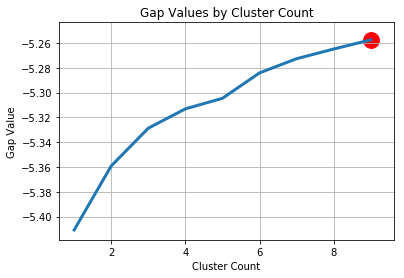

In [16]:
n_cluster,optK = gapStat(XFinal,10)
gapsPlt(n_cluster,optK)

In [13]:
optK.gap_df.head()

gap_value  n_clusters
0  -5.410166         1.0
1  -5.360272         2.0
2  -5.339898         3.0
3  -5.319510         4.0
4  -5.298183         5.0

# Solhouette analysis to determine the optimal number of clusters

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.0497569351136


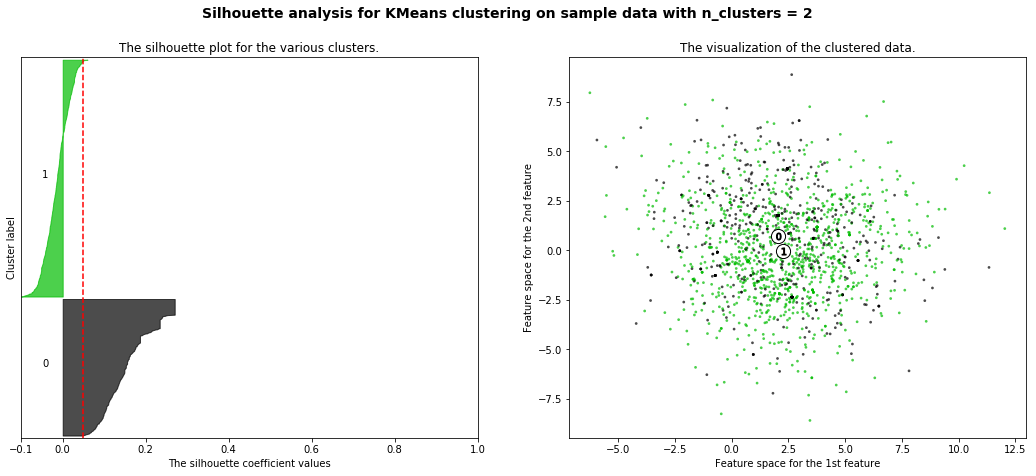

For n_clusters = 3 The average silhouette_score is : 0.0633185182845


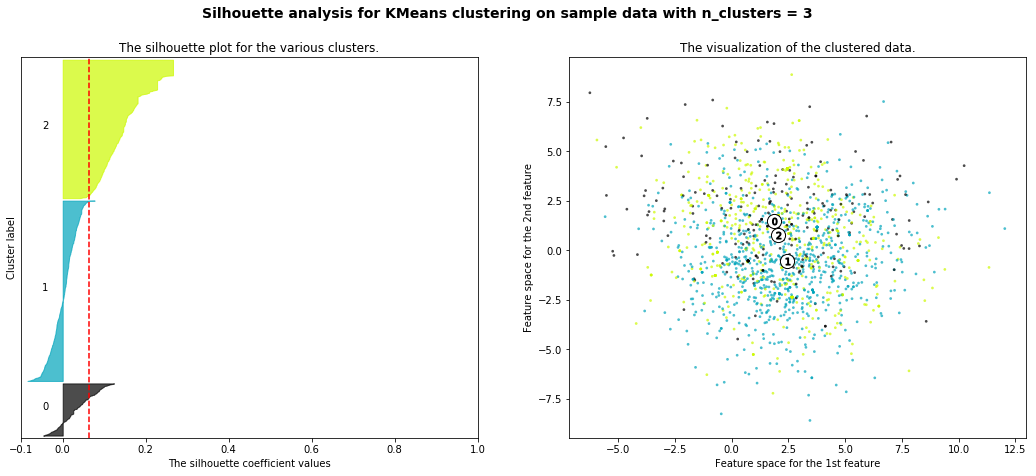

For n_clusters = 4 The average silhouette_score is : 0.0603271539243


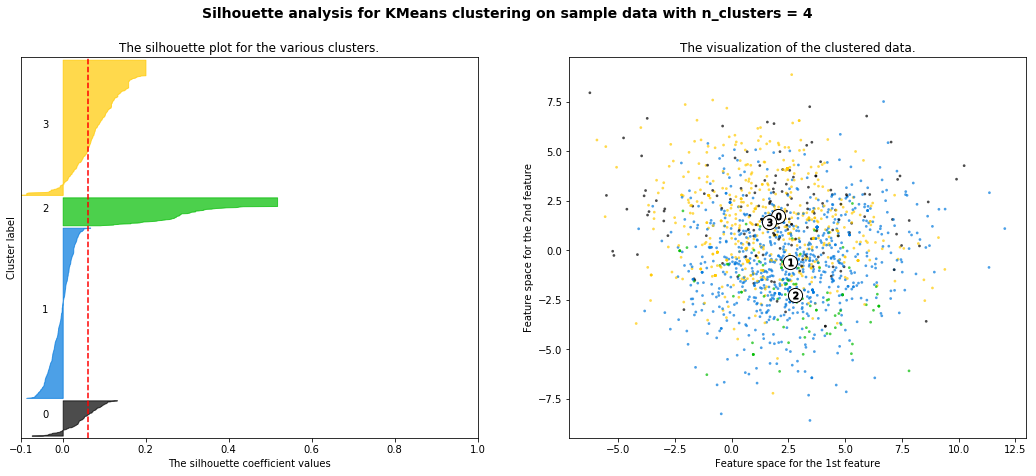

For n_clusters = 6 The average silhouette_score is : 0.0683448639604


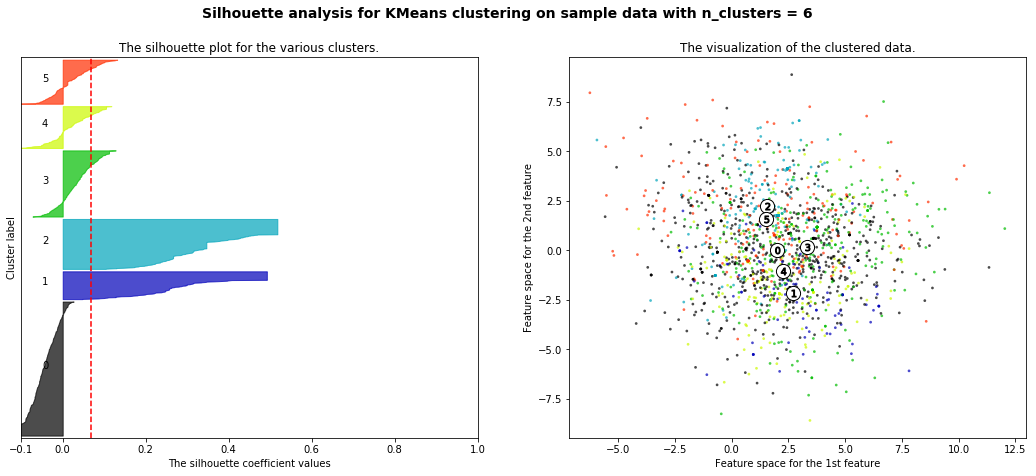

For n_clusters = 8 The average silhouette_score is : 0.0817743794985


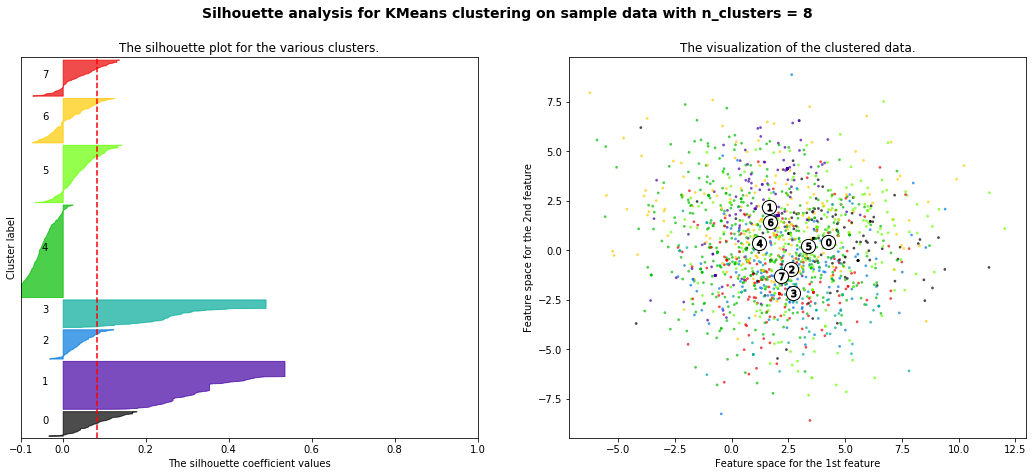

For n_clusters = 10 The average silhouette_score is : 0.0862812780276


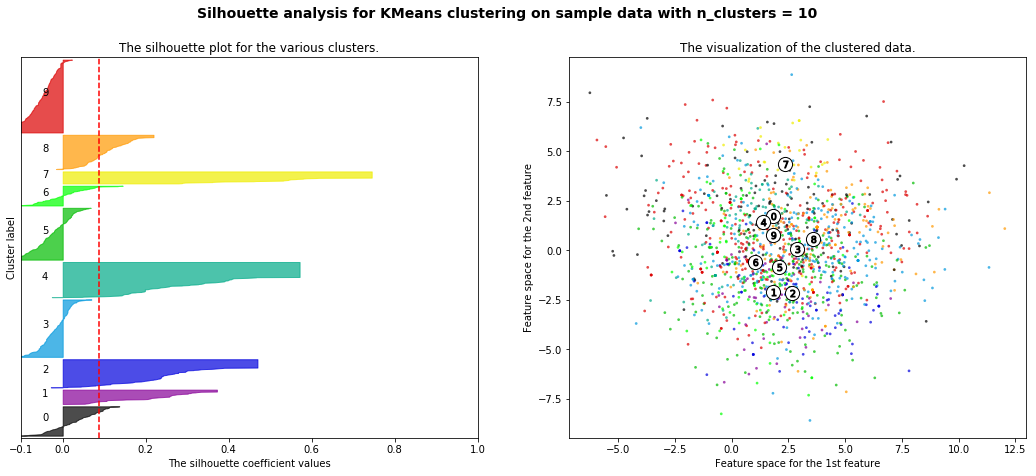

For n_clusters = 12 The average silhouette_score is : 0.0967247109434


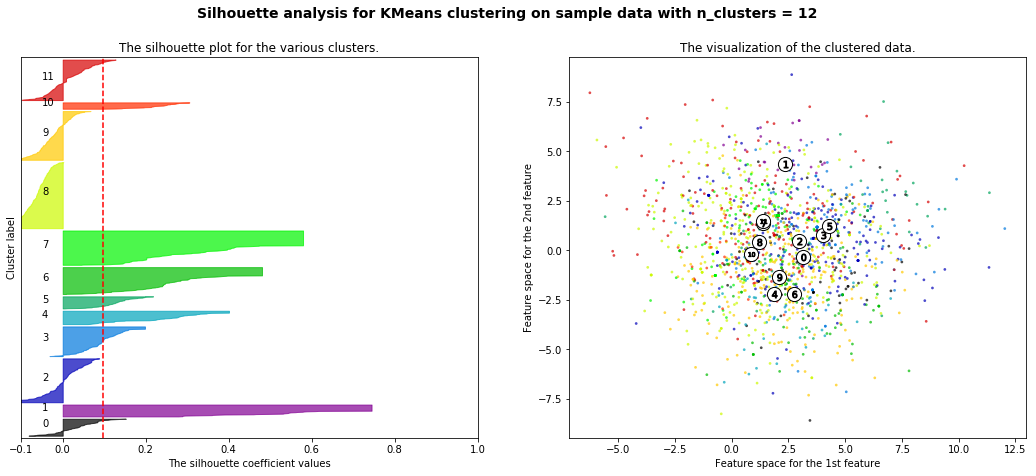

For n_clusters = 14 The average silhouette_score is : 0.108160748715


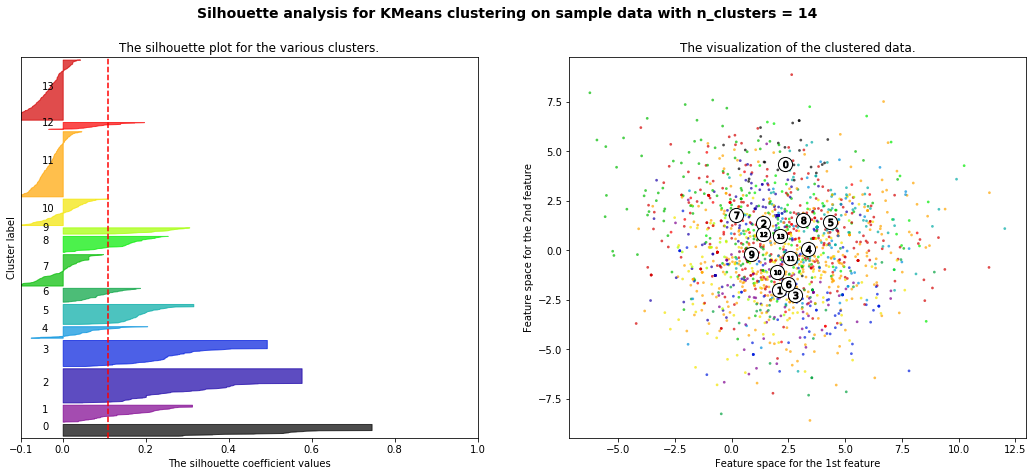

For n_clusters = 16 The average silhouette_score is : 0.123719253423


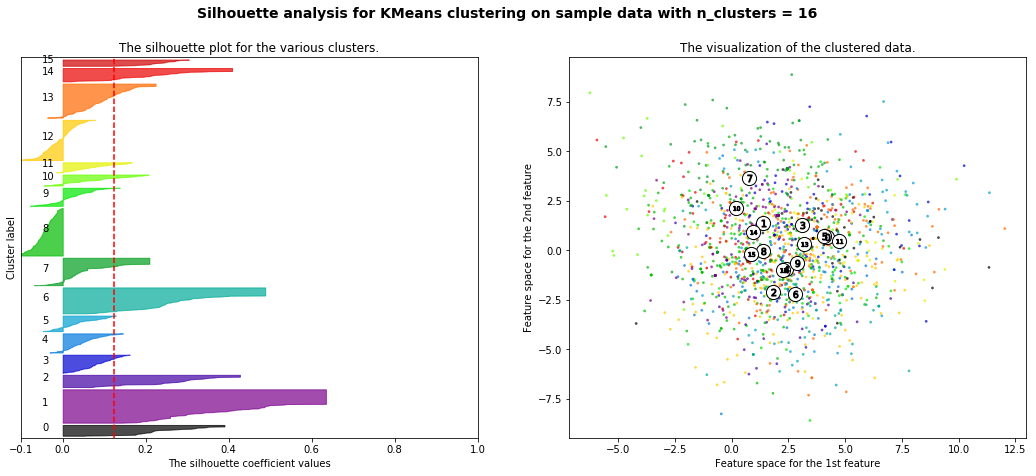

In [38]:

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
# X, y = make_blobs(n_samples=500,
#                   n_features=2,
#                   centers=4,
#                   cluster_std=1,
#                   center_box=(-10.0, 10.0),
#                   shuffle=True,
#                   random_state=1)  # For reproducibility
X = XFinal[:1500]
y = km.labels_[:1500]

range_n_clusters = [2, 3,4,6,8]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

# First level clustering

In [17]:
import time
start_time = time.time()
km = KMeans(n_clusters = 7,
           init = 'k-means++',
           n_init = 10,
           max_iter = 5000,
           random_state = 0)
km.fit(XFinal)
end_time = time.time()
print("Time to Run in seconds:  ", end_time-start_time)

Time to Run in seconds:   8.86919617652893


# Save kmeans object

 # Multi-level clustering
 ## Form dict for first level clusters(key: number of cluster, value: list of labels (index of vector in the original VectorizefNPsDF))


In [18]:
import pandas as pd
cluster_map = pd.DataFrame()
cluster_map['data_index'] = VectorizedDf['Vector'].index.values
cluster_map['cluster'] = km.labels_

In [19]:
clusters = {}
for i in range(0,km.n_clusters):
    clusters["cluster{0}".format(i)]=cluster_map[cluster_map.cluster == i]['data_index']

In [20]:
clustersValues ={}
child1 = []
for i in range(0,len(clusters.keys())):
    temp = pd.DataFrame(clusters["cluster{0}".format(i)])
    clustersValues["clustersValues{0}".format(i)] = pd.DataFrame(VectorizedDf.loc[temp['data_index']]['Vector'])
    
    shapedArray = np.zeros(shape=(len(clustersValues["clustersValues{0}".format(i)]),word2VecModel.vector_size))
    temp = pd.DataFrame.as_matrix(clustersValues["clustersValues{0}".format(i)]['Vector'])
    for j in range(len(clustersValues["clustersValues{0}".format(i)]['Vector'])):
        shapedArray[j] = temp[j]
    child1.append(shapedArray)

# Estimate optimal number of clusters 

8 for  4407


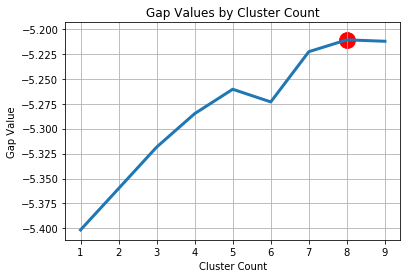

9 for  5240


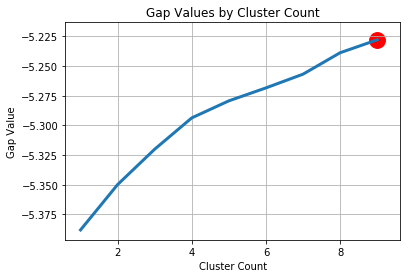

9 for  2441


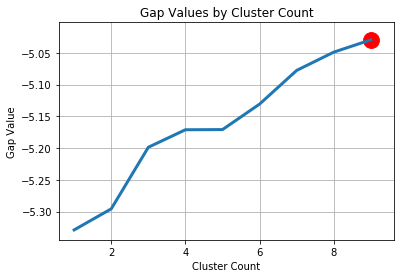

9 for  4209


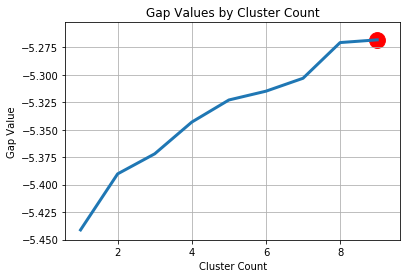

8 for  13357


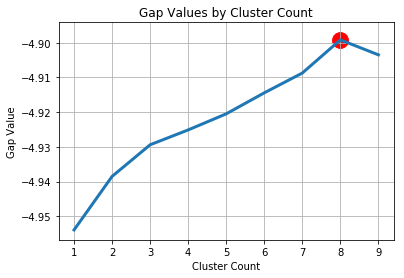

9 for  4224


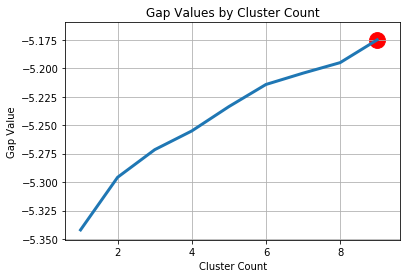

9 for  3017


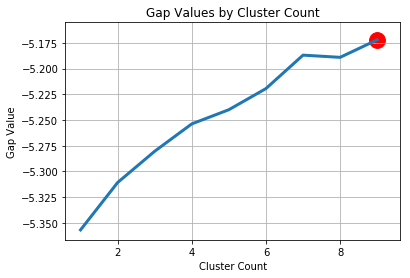

In [21]:
numOfVectors =[]
for i in child1:
    if len(i) <= 500:
        n,optK= gapStat(i,4)
        print(n , 'for ',len(i))
        numOfVectors.append(len(i))
        gapsPlt(n_clusters=n,optimalK=optK)
    elif len(i) > 500 and len(i) <= 1500:
        n,optK= gapStat(i,6)
        print(n , 'for ',len(i))
        numOfVectors.append(len(i))
        gapsPlt(n_clusters=n,optimalK=optK)
    else:
        n,optK= gapStat(i,10)
        print(n , 'for ',len(i))
        numOfVectors.append(len(i))
        gapsPlt(n_clusters=n,optimalK=optK)  

In [22]:
numOfOptClustersSecondLevel = []
numOfOptClustersSecondLevel.append(8)
numOfOptClustersSecondLevel.append(8)
numOfOptClustersSecondLevel.append(9)
numOfOptClustersSecondLevel.append(8)
numOfOptClustersSecondLevel.append(9)
numOfOptClustersSecondLevel.append(8)
numOfOptClustersSecondLevel.append(9)
print(numOfOptClustersSecondLevel)

[8, 8, 9, 8, 8, 8, 8]


In [24]:
kmeansSecondLevel =[]
for i in range(len(numOfOptClustersSecondLevel)):
    start_time = time.time()
    km = KMeans(n_clusters = numOfOptClustersSecondLevel[i],
               init = 'k-means++',
               n_init = 10,
               max_iter = 5000,
               random_state = 0
               )
    km.fit(child1[i])
    end_time = time.time()
    kmeansSecondLevel.append(km)
    print("Time to Run in seconds:  ", end_time-start_time)

Time to Run in seconds:   0.7333488464355469
Time to Run in seconds:   1.1155736446380615
Time to Run in seconds:   0.37208104133605957
Time to Run in seconds:   0.834791898727417
Time to Run in seconds:   3.5889434814453125
Time to Run in seconds:   0.8823902606964111
Time to Run in seconds:   0.5499162673950195


# Save list of Kmeans

In [53]:
list_pickle_path = 'Kmeans\\list_of_Kmeans_2nd_level100.pkl'
list_pickle = open(list_pickle_path,'wb')
pickle.dump(kmeansSecondLevel,list_pickle)
list_pickle.close()

# Show NPs in the first level cluster

In [27]:
print(len(clustersValues['clustersValues2']))
test = VectorizedDf.loc[clustersValues['clustersValues2']['Vector'].index.values,:]
test

2441


NP  \
0                 شعرعلي الوجه   
2                  عضلات الراس   
31                 طبيعة الجلد   
49                 الشعر دهنيا   
61       ولاتعب لتبييض الاسنان   
71          وسماكة جلد القدمين   
98                  فروة الشعر   
136              جروح في الجلد   
141             البشرة بالتنفس   
180                 بثور الراس   
210              الشعر بالخليط   
231              الشعر بالمزيج   
250                  شعر الابط   
256                  فتح الجلد   
324         والتهاب فروة الراس   
338          البكتيريا العالقة   
362            بفرك جلده الراس   
368    والفرشاة لتبييض الاسنان   
372       فطريات الشعر بالزيوت   
373                  لكل الراس   
385                ويدلك الراس   
432                 قشور جلدية   
453             الجلد الطبيعية   
496                تالق البشرة   
504               الشعر الخاصة   
540                  فرك الجسم   
541             البشرة بالخليط   
561            الشيخوخه المبكر   
566                وقشور الراس   
582              اظافر القدمين   
...                        ...   
43121             وتهدءة الجلد   
43135             الشيب المبكر   
43139    العيون المصابة بالرمد   
43144     علامات السن المتقدمه   
43172       راءحة العرق بالطبع   
43188      طفيليات تهاجم الجلد   
43196                سطح الجلد   
43206             جانبي الرقبة   
43209           وتنشيف القدمين   
43212            لنعومة البشرة   
43222                وقرح الفم   
43232        والتصاقات الاسنان   
43243          الاسنان المسوسة   
43265               قناع الوجه   
43269             الشعر الزاءد   
43276              اجزاء الشعر   
43279             الشعر المرضي   
43291                شد البشرة   
43300             والارق الراس   
43301            وصفات الاسنان   
43338            وتقشير البشرة   
43341           لتبييض الاسنان   
43346      جفاف وخشونة القدمين   
43360            الانف المحتقن   
43387                 وش الجلد   
43391          للثاليل الدمامل   
43415             دهن في الاذن   
43469         حرارة باطن القدم   
43518               اثار الوجه   
43555                   الرقبة   

                                                  Vector  
0      [-2.16722, 2.92223, -0.0891994, 0.617062, -1.2...  
2      [-17.2951, 1.97294, 4.69114, -6.95093, 3.11683...  
31     [-2.07442, 10.5887, -2.02564, 7.86248, -3.1536...  
49     [-9.93628, 8.47673, 4.70705, -0.256859, 2.1689...  
61     [-1.62649, -1.55375, -4.76007, 4.76487, 0.2892...  
71     [-7.52971, 4.82703, 0.490667, -4.39932, 0.4125...  
98     [-14.195, 12.9177, 2.67867, -1.75395, 2.24487,...  
136    [-8.66716, -0.113076, -1.93994, 8.91111, 1.156...  
141    [-4.14913, 2.18242, -4.86179, 1.86366, 0.12755...  
180    [-12.6443, 2.87873, 6.50185, 2.23323, 2.78531,...  
210    [-11.519, 7.09978, 1.39957, -0.602743, -0.3447...  
231    [-9.96812, 6.18641, 9.05386, 1.18257, -0.30253...  
250    [-9.8428, 2.13748, 0.0941005, -0.693069, 6.386...  
256    [-2.18686, 0.446217, 3.03543, 2.18747, -4.7996...  
324    [-15.5466, 2.52121, 5.28893, -5.97037, 1.08331...  
338    [-2.07465, 4.39354, 1.1089, 6.75127, 6.61504, ...  
362    [-13.2816, 4.94561, 3.7139, -6.93279, -0.00318...  
368    [-1.62649, -1.55375, -4.76007, 4.76487, 0.2892...  
372    [-15.9911, 19.4423, 10.0584, -0.584889, 4.3846...  
373    [-10.1703, 6.74047, -1.65723, 3.79673, 4.93825...  
385    [-3.35945, 0.808194, 3.45135, -9.96383, 1.9623...  
432    [-4.22003, -4.45768, -0.235659, 1.63894, 2.365...  
453    [-5.53233, 3.84289, 1.42036, -1.34564, -2.4467...  
496    [-7.40778, 2.78811, -3.08053, 5.30792, 1.98059...  
504    [-6.1614, 6.92842, 7.81899, -3.14586, 0.674813...  
540    [-1.92072, -1.70401, 4.568, -2.54223, -5.63389...  
541    [-5.35336, 3.24658, -8.32759, 2.66819, -4.5761...  
561    [-5.96503, 9.16595, 1.62197, 5.24743, 6.58716,...  
566    [-13.4891, 8.87287, 1.79776, -3.88444, 2.57049...  
582    [-5.9306, -1.39973, 4.14758, -4.47201, 0.71961...  
...                                                  ...  
43121  [-5.11001, 0.39881, -0.2

In [28]:
def makeDict(idx,labels):
    import pandas as pd
    cluster_map = pd.DataFrame()
    cluster_map['data_index'] = idx
    cluster_map['cluster'] = labels
    
    clusters = {}
    for i in range(0,len(set(labels))):
        clusters["cluster{0}".format(i)]=cluster_map[cluster_map.cluster == i]['data_index']
    
    clustersValues ={}
    child1 = []
    cv = list()
    for i in range(0,len(clusters.keys())):
        temp = pd.DataFrame(clusters["cluster{0}".format(i)])
        clustersValues["clustersValues{0}".format(i)] = pd.DataFrame(VectorizedDf.loc[temp['data_index']]['Vector'])

        shapedArray = np.zeros(shape=(len(clustersValues["clustersValues{0}".format(i)]),word2VecModel.vector_size))
        temp = pd.DataFrame.as_matrix(clustersValues["clustersValues{0}".format(i)]['Vector'])
        for j in range(len(clustersValues["clustersValues{0}".format(i)]['Vector'])):
            shapedArray[j] = temp[j]
        child1.append(shapedArray)
        cv.append(VectorizedDf.loc[clustersValues["clustersValues{0}".format(i)]['Vector'].index.values,:])
    return cv,child1

 # Form another dict for each cluster from the above dict (second level)

In [30]:
def makeDictswholeLevel(l):
    clusterValuesDFs = []
    childsList = []
    for i in range(l):
        labels = (kmeansSecondLevel[i]).labels_
        c = 'cluster'+str(i)
        idx = clusters[c]
        clusterValuesDF,child = makeDict(idx,labels)
        clusterValuesDFs.append(clusterValuesDF)
        childsList.append(child)
    return clusterValuesDFs,childsList

In [31]:
l = len(kmeansSecondLevel)
clusterValuesDFs,childsList = makeDictswholeLevel(l)

In [184]:
((clusterValuesDFs[1][2]))
# print(clusterValuesDFs[1][2])
# classesTobecluster = [0][3][944]
# classesTobecluster = [0][7][1401]
# classesTobecluster = [1][0][8000]
# classesTobecluster = [1][1][1400]
# classesTobecluster = [1][4][1500]
# classesTobecluster = [1][6][2985]
# classesTobecluster = [2][6][497]
# classesTobecluster = [3][7][1085]
# classesTobecluster = [5][1][844]
# classesTobecluster = [5][5][1481]
# classesTobecluster = [6][6][1764]

NP                                             Vector
83               وجع المعدة  [0.284564, -1.18089, 2.58951, -6.45244, -1.273...
213         الحمض في المعدة  [-0.558435, -1.35929, -4.73088, -7.24523, -9.7...
291       ارخاء صمام المعدة  [-4.9681, -6.40797, -4.97114, -6.9487, -2.0155...
295         بالاعشاب المعدة  [-0.827014, 1.38301, -1.10696, -6.09031, -4.71...
407    القولون انبوبا عضليا  [-1.42669, 1.46371, -5.40364, 2.39771, -1.2843...
730         الغازات الزاءدة  [-1.04455, 1.26542, 3.08572, 2.81314, -3.24053...
737       تشنج عضلات المعدة  [-13.7037, -6.73897, -6.39431, -8.58452, -2.05...
911      اعراض حموضة المعدة  [-9.70058, -8.01516, 4.07925, -3.94457, 4.6701...
931           تدريب الامعاء  [-1.45271, 2.55603, -6.00329, -2.33582, -3.680...
960             كسل الامعاء  [-7.73925, -0.862514, -3.59323, -5.02927, 0.86...
1075          والمغص المعدي  [-1.25521, -6.36891, -6.85744, -4.42034, -5.27...
1121       الالام في المعدة  [-4.86179, -4.40574, -3.13145, -5.29784, 0.075...
1129           وينبه المعدة  [-0.189842, -6.79549, -3.41059, -5.3697, -9.66...
1167     الانقباضات الدودية  [-7.52095, -3.06794, -7.14129, 4.49205, 1.7956...
1193             راس المعدة  [-7.17949, -2.9738, -4.38812, -1.1421, -6.1399...
1201          عضلات الامعاء  [-13.4865, 0.457248, -5.10655, -7.57531, -1.25...
1283           مخاط القولون  [0.470845, 2.45297, -2.91133, 2.56609, 0.93048...
1301                 المعدة  [-1.06996, -2.60633, -3.09791, -3.9576, -7.419...
1359           امراض المعدة  [-4.69956, -7.33285, -0.283208, -4.31267, -1.2...
1360          بتنشيط المعدة  [-2.82159, -3.69464, -6.90002, -6.48901, -6.56...
1386           وقروح المعدة  [-5.42539, -8.16777, -2.66561, -7.36045, -5.71...
1436              عسر الهضم  [-7.53008, -1.70947, -1.12131, 3.22066, -5.412...
1439   لذوات المعدة الضعيفة  [-2.57964, -5.78564, -1.10982, -6.06186, -8.37...
1510          وتعتبر المعدة  [-1.95766, -3.32622, -6.34545, -3.07226, -10.7...
1690                 الهضمي  [-5.51359, -0.933308, -1.52923, 2.63621, -2.45...
1808       التقلصات بالمعدة  [-5.37761, -4.21493, -1.95785, 2.33261, -6.242...
1947           حماية المعدة  [-2.16565, -0.300393, 0.200184, -5.69221, -4.2...
1962          ويليين المعدة  [-1.06996, -2.60633, -3.09791, -3.9576, -7.419...
1983          عفونة الامعاء  [-4.87904, 0.619045, -5.06325, -1.73024, -4.32...
1994        بقرحة في المعدة  [-7.01543, -8.55788, -2.24463, -2.48793, -7.00...
...                     ...                                                ...
41212      انتفاخ في المعدة  [-3.46258, -4.18941, 3.16675, -4.49333, -7.803...
41287          قرحات الاثني  [-2.33743, -4.83902, -9.79078, -0.304617, -4.2...
41372         الجهاز المعوي  [-2.49585, 1.50879, -3.89064, -0.444313, -4.98...
41374        قروح في المعدة  [-6.53895, -1.97156, -2.21106, -0.919972, -9.0...
41385          حموضة المعدة  [-5.50887, -5.47206, 1.82674, -3.06672, -3.108...
41465       لبكتريا الامعاء  [-5.17739, 2.52703, -6.0905, -2.0039, -5.02746...
41473          لكسل الامعاء  [-5.17739, 2.52703, -6.0905, -2.0039, -5.02746...
41757       لاضطرابات الهضم  [-7.47844, -2.1661, -4.08588, 0.784794, -5.078...
41806           قرحة للمعدة  [-1.04209, -8.40347, 1.58612, 0.384683, -0.985...
41861          عسر في الهضم  [-7.53008, -1.70947, -1.12131, 3.22066, -5.412...
41872          غازات المعدة  [-2.14945, -7.04992, 0.394692, -6.9729, -8.954...
41894         لضعفاء المعدة  [-1.06996, -2.60633, -3.09791, -3.9576, -7.419...
41913  انتفاخ وغازات المعدة  [-3.43452, -2.8843, 2.72175, -1.03298, -5.8048...
42004         ديديان المعده  [-4.0889, -0.515795, -4.12991, 3.62512, -4.757...
42071             فم المعدة  [-1.06996, -2.60633, -3.09791, -3.9576, -7.419...
42147  الشعور بحموضة المعدة  [6.48367, -6.04771, 3.12713, -7.53962, -4.6999...
42281          تعقيم المعدة  [-2.95084, -1.97478, -4.42601, 0.253137, -3.62...
42692      والغازات المعويه  [-7.4394, -6.68063, -1.91938, -0.649202, -1.36...
42693  ويقوي المعدة الضعيفة  [-2.90576, -17.7492, 5.26029, -4.53539, -6.587

# Save clusters as Dataframes

In [319]:
for i in range(len(clusterValuesDFs)):
    for j in range(len(clusterValuesDFs[i])):
        (clusterValuesDFs[i][j]['NP']).to_csv('Clustering Stage\\Clusters\\'+str(i)+'_'+str(j)+'.txt',encoding='utf-8',index = False)

# Number of samples per cluster in second level

In [114]:
import collections
for i in range(len(kmeansSecondLevel)):
    unique, counts = np.unique(kmeansSecondLevel[i].labels_, return_counts=True)
    print(dict(zip(unique, counts)))

{0: 257, 1: 658, 2: 797, 3: 508, 4: 314, 5: 251, 6: 296, 7: 1326}
{0: 677, 1: 781, 2: 678, 3: 1066, 4: 433, 5: 795, 6: 601, 7: 209}
{0: 83, 1: 304, 2: 378, 3: 382, 4: 332, 5: 438, 6: 159, 7: 198, 8: 167}
{0: 697, 1: 563, 2: 314, 3: 463, 4: 756, 5: 375, 6: 582, 7: 459}
{0: 506, 1: 1301, 2: 1531, 3: 2068, 4: 5456, 5: 1334, 6: 569, 7: 592}
{0: 394, 1: 913, 2: 226, 3: 851, 4: 782, 5: 512, 6: 247, 7: 299}
{0: 276, 1: 339, 2: 480, 3: 852, 4: 474, 5: 186, 6: 184, 7: 226}


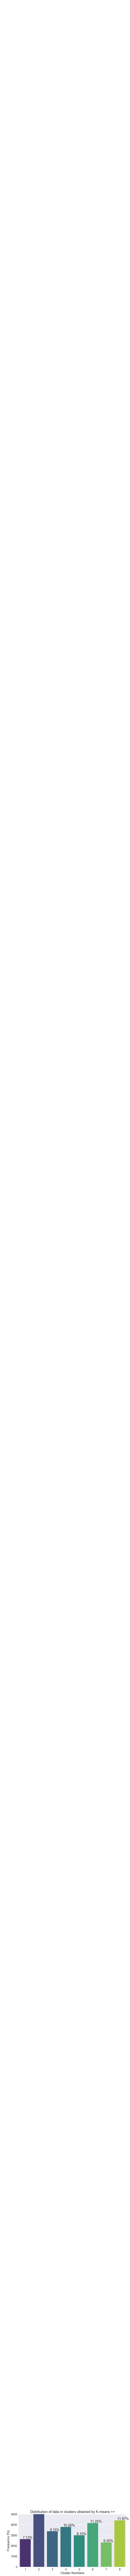

In [127]:
labels = (km).fit_predict(XFinal)
clusters = list(map(lambda x: x+1, labels))
ax = sns.countplot(x = clusters ,palette="viridis")
sns.set(font_scale=1.5)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=5000)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(clusters)), (p.get_x()+ 0.2, p.get_height()+ 40))

plt.title('Distribution of data in clusters obtained by K-means ++' )
plt.xlabel('Cluster Numbers')
plt.ylabel('Frequency [%]')
plt.show()
    

# Visualize cluster\num of samples distribution for all leaves clusters

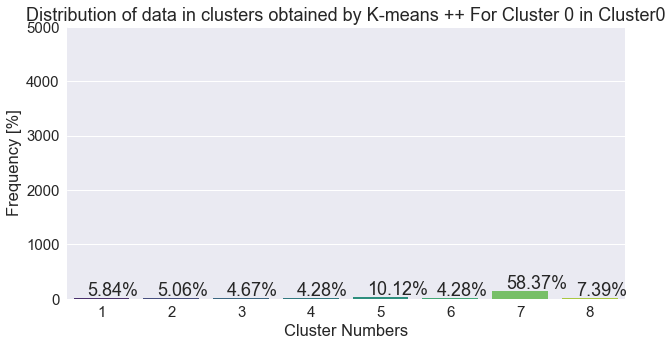

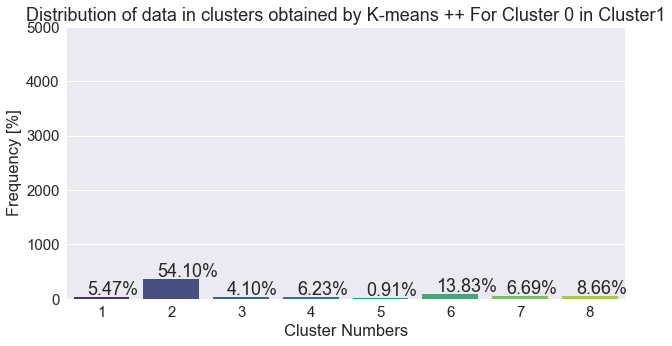

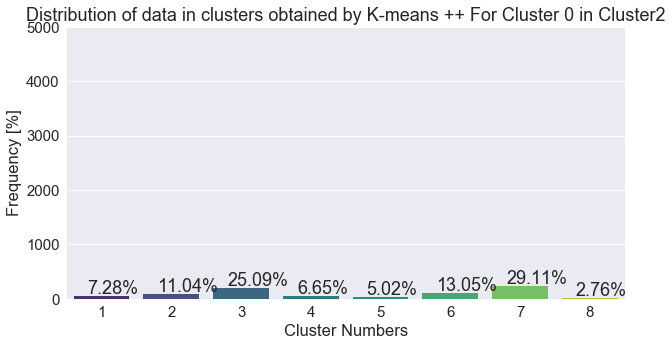

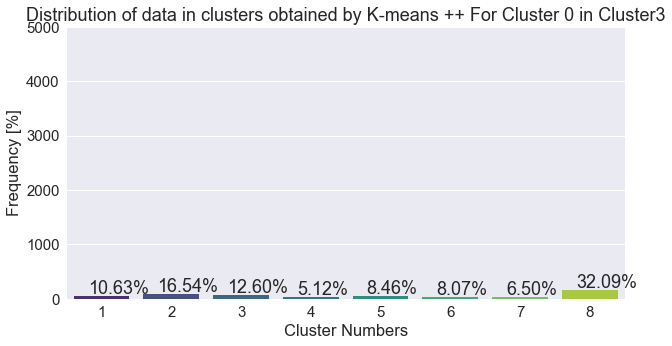

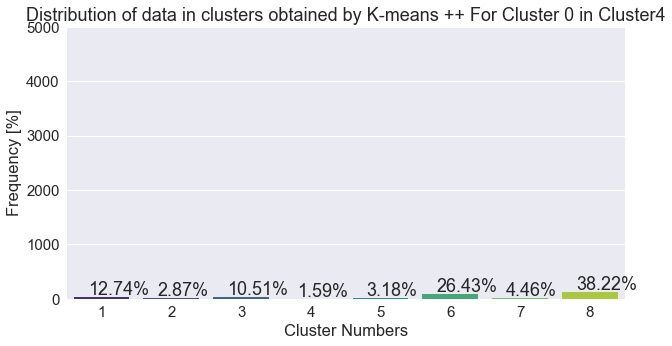

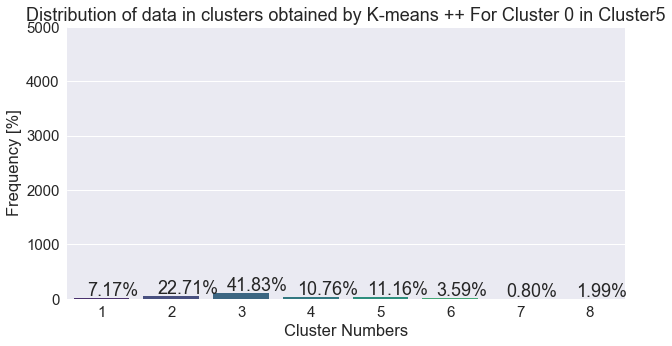

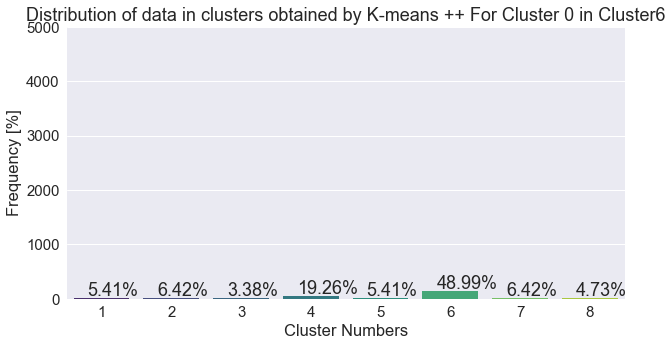

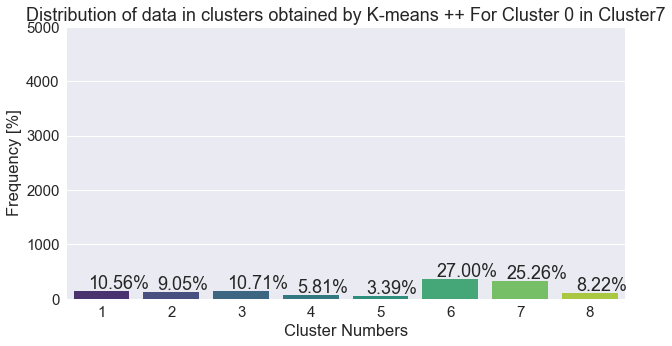

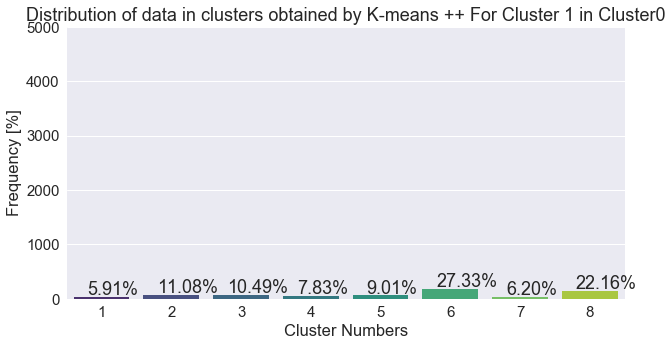

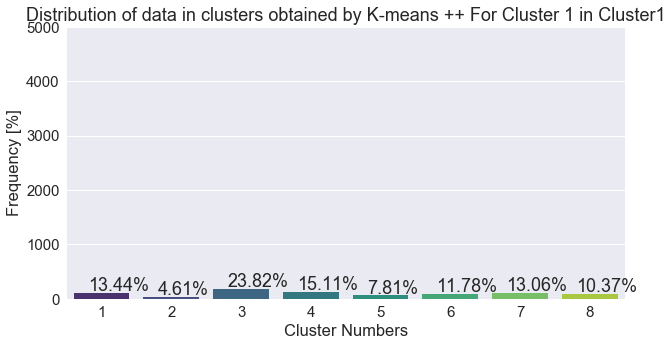

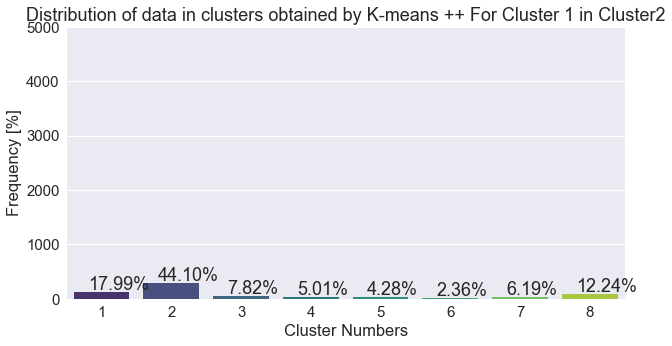

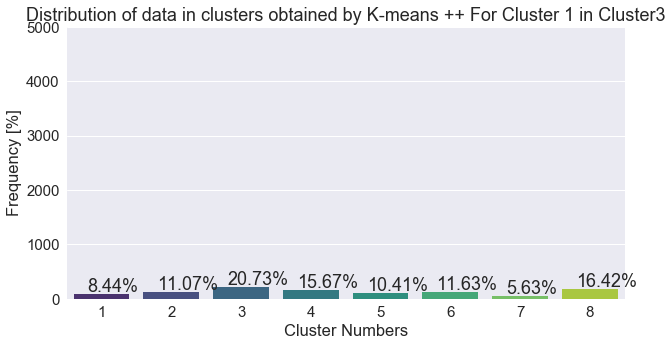

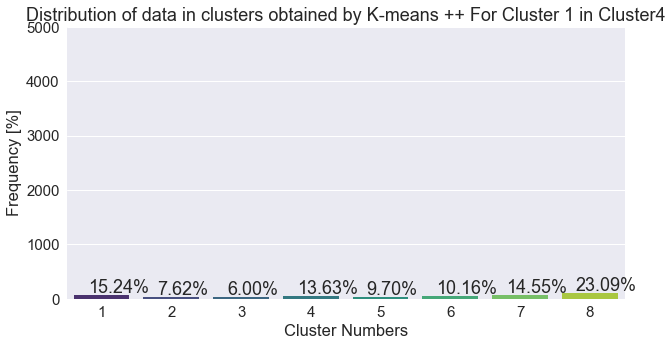

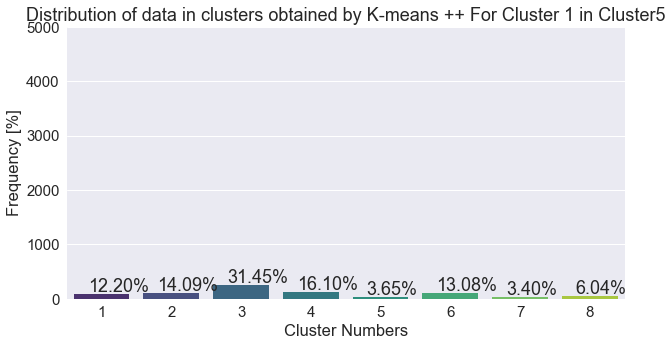

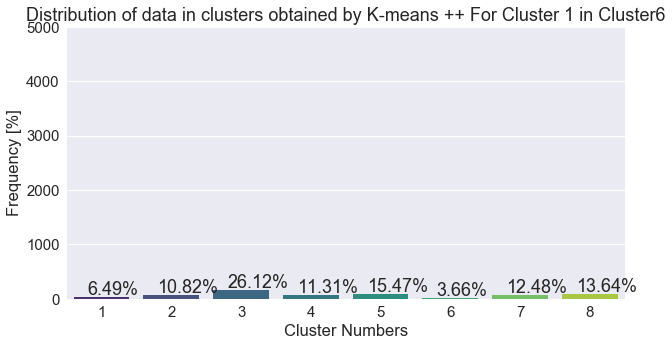

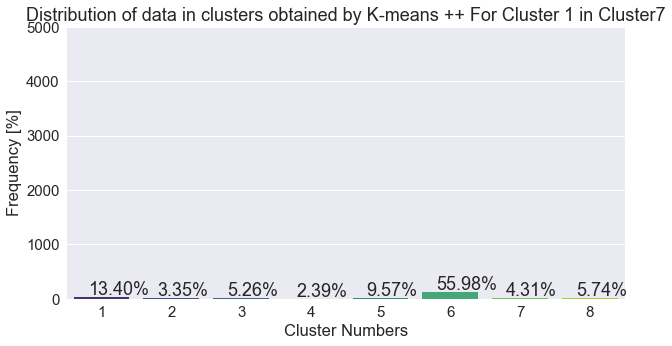

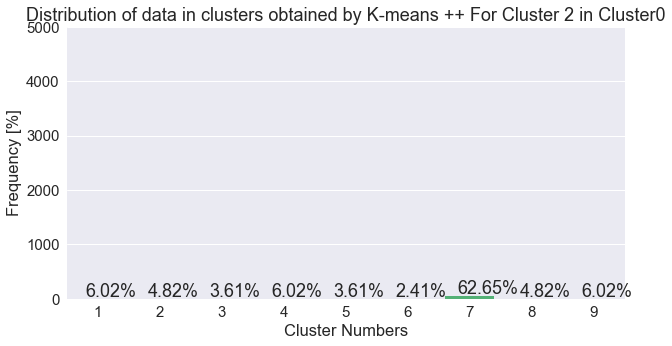

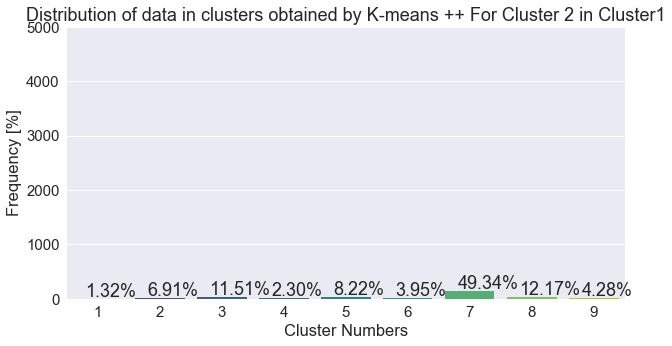

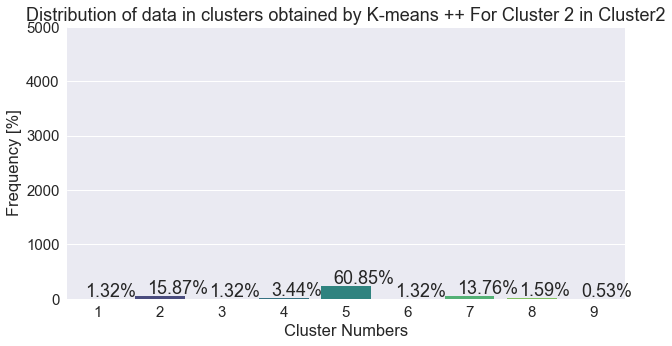

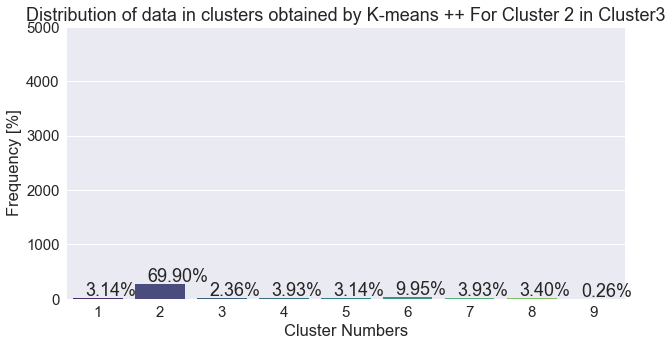

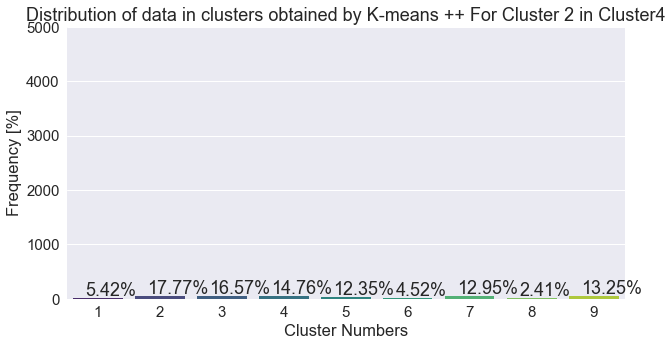

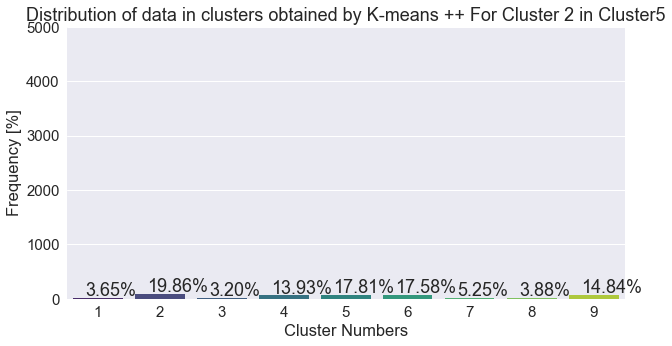

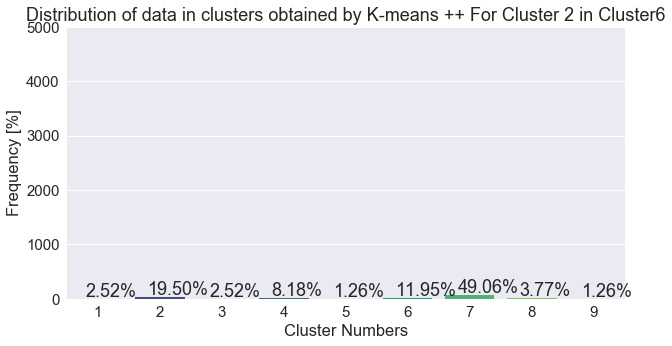

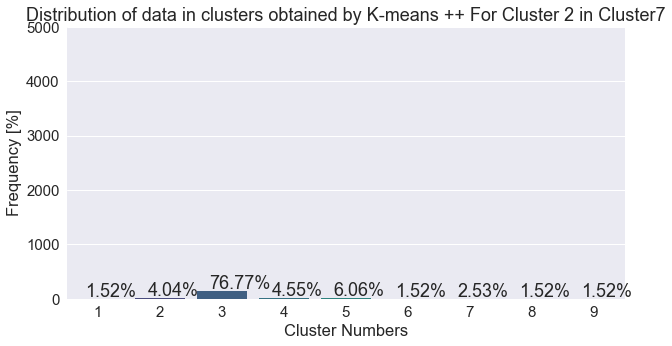

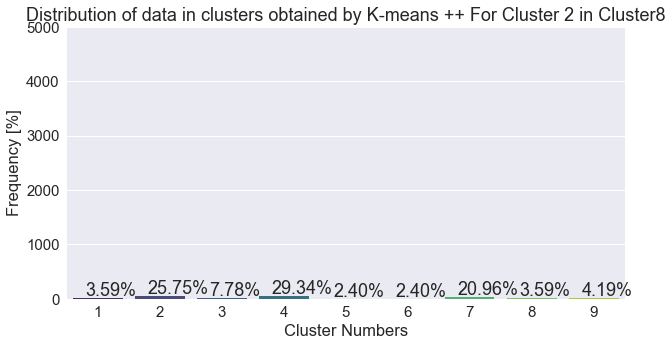

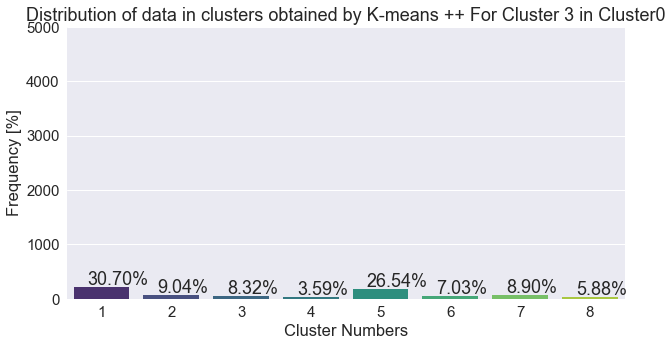

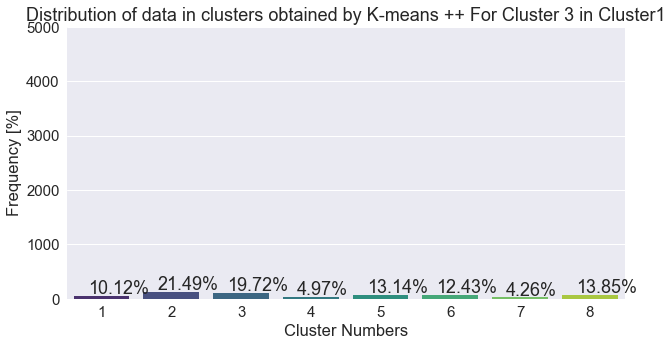

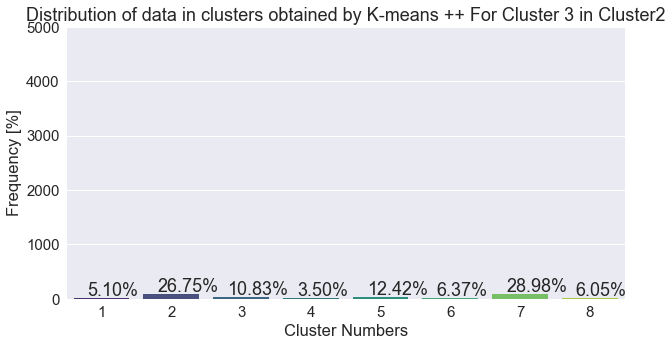

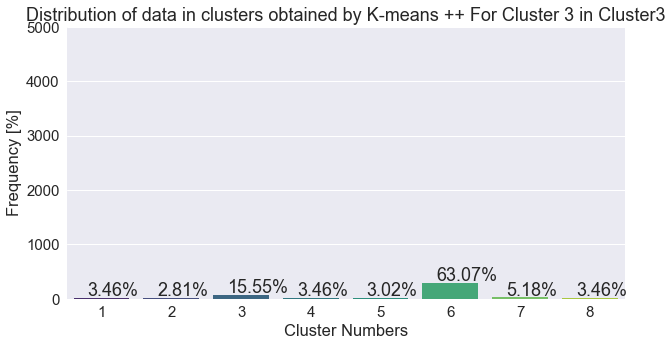

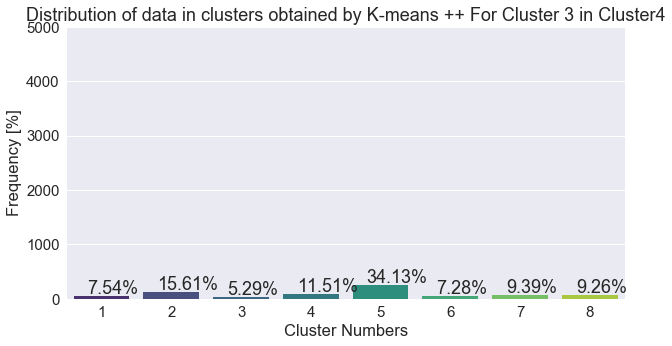

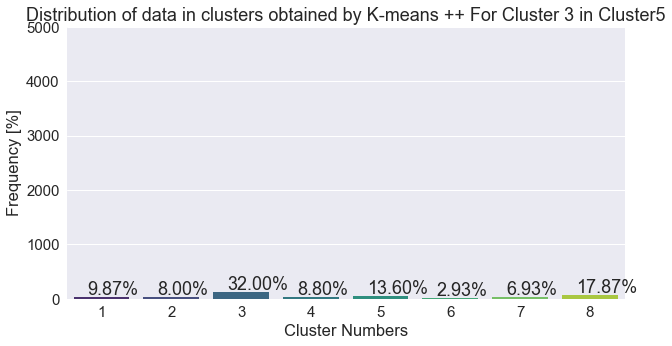

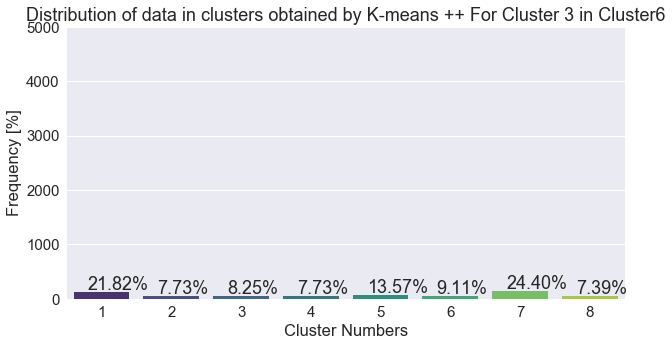

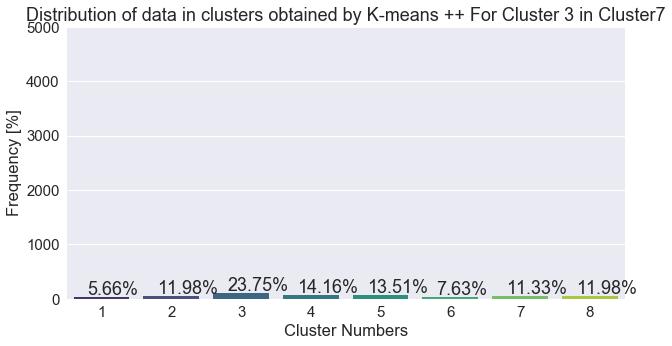

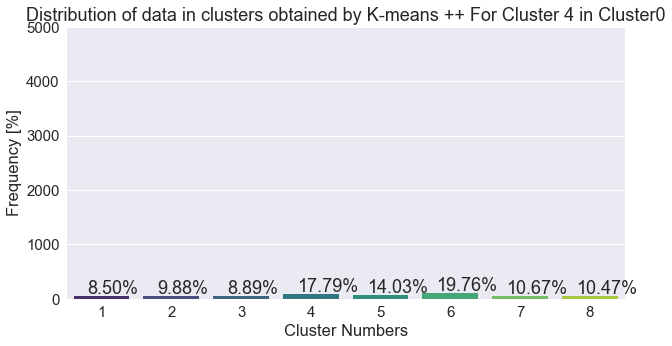

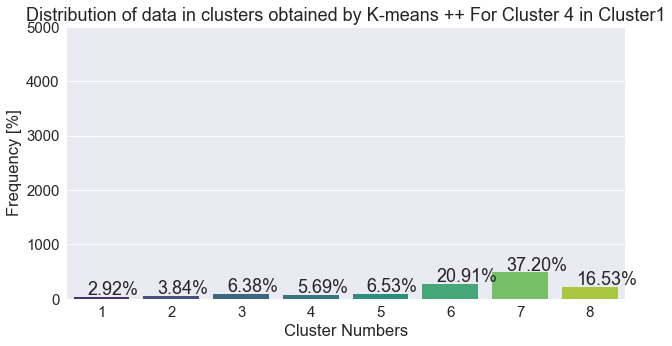

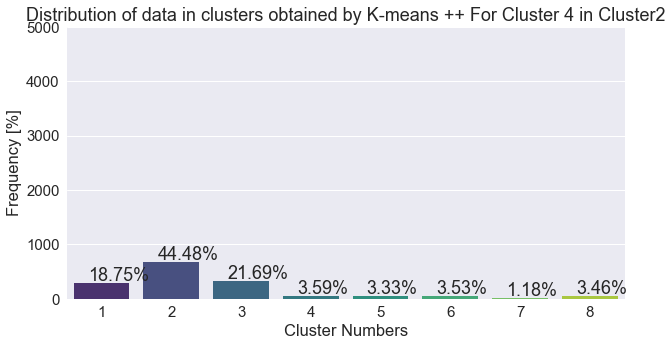

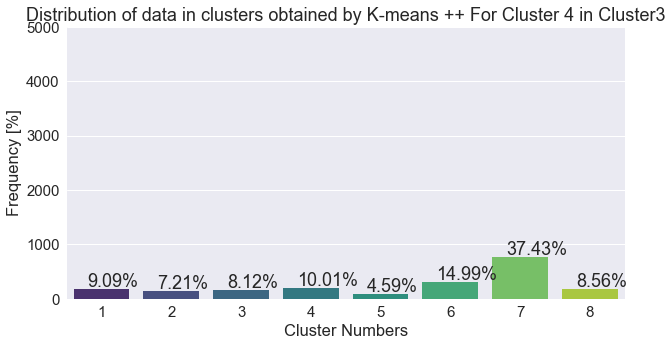

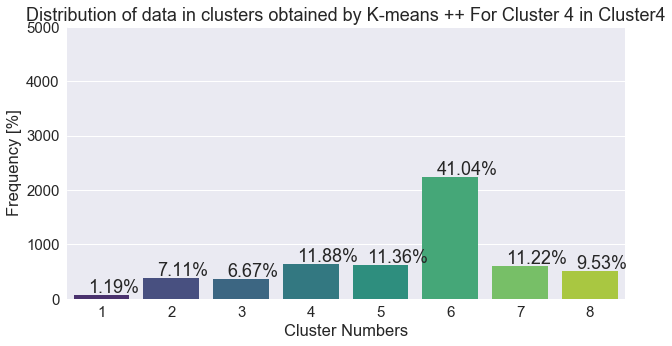

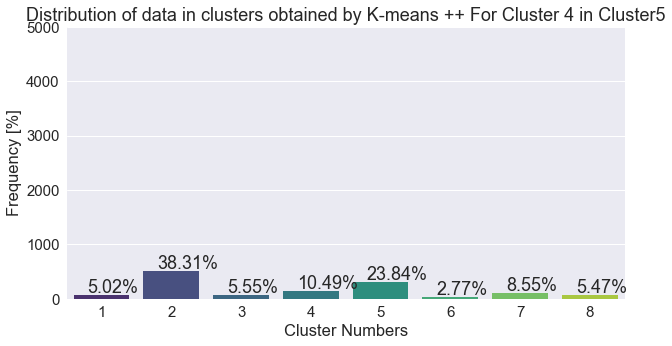

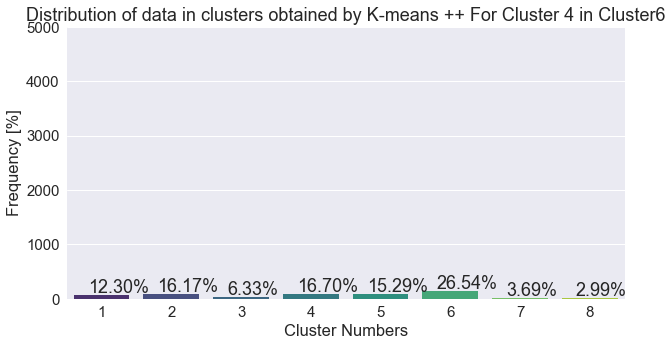

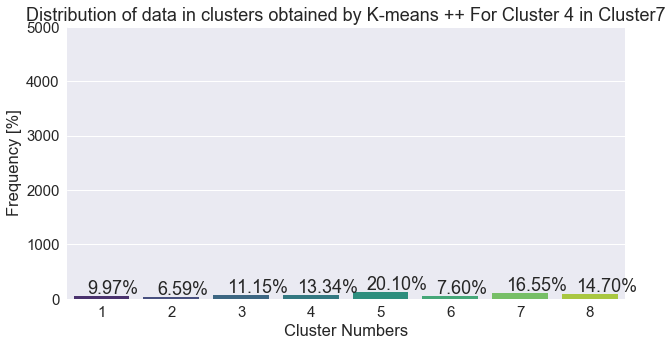

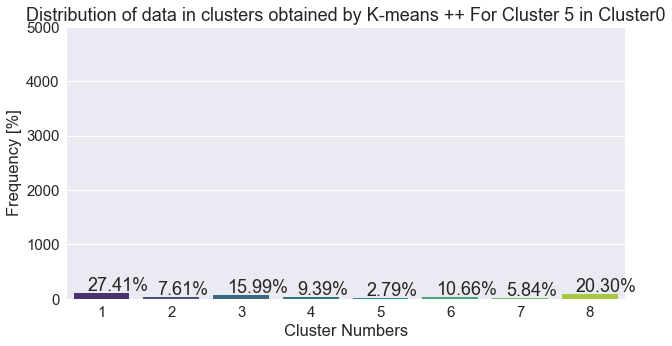

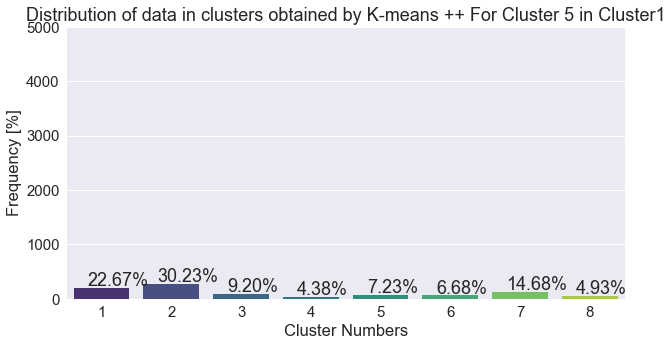

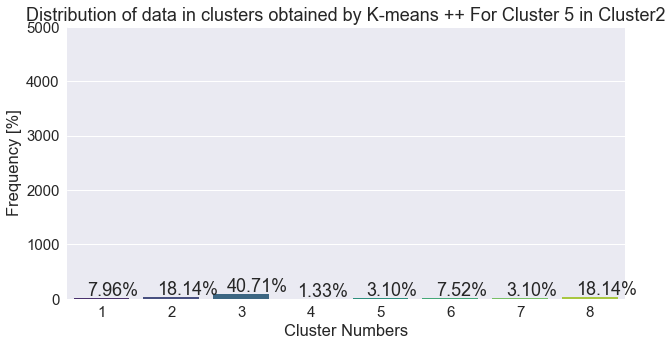

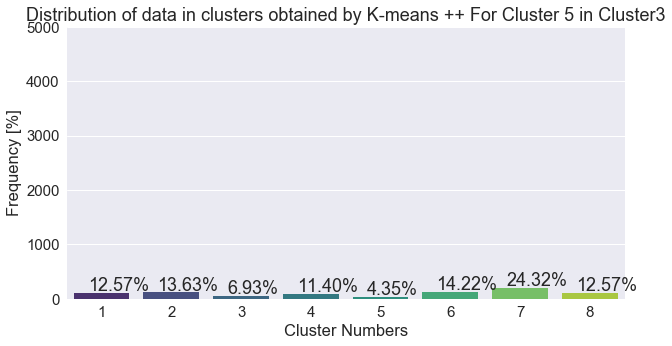

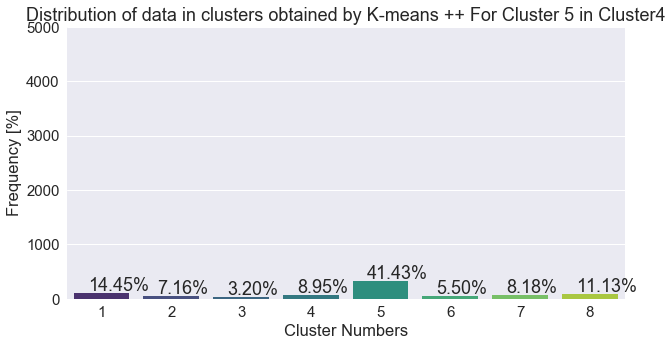

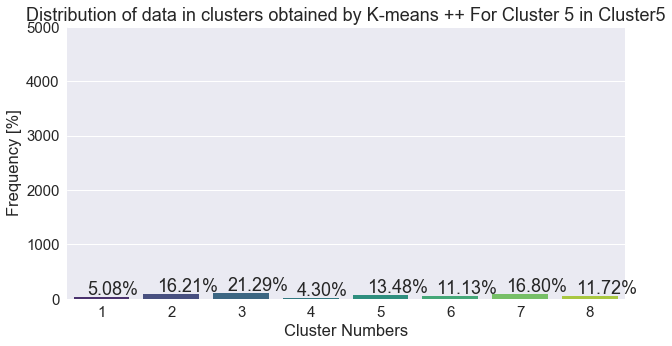

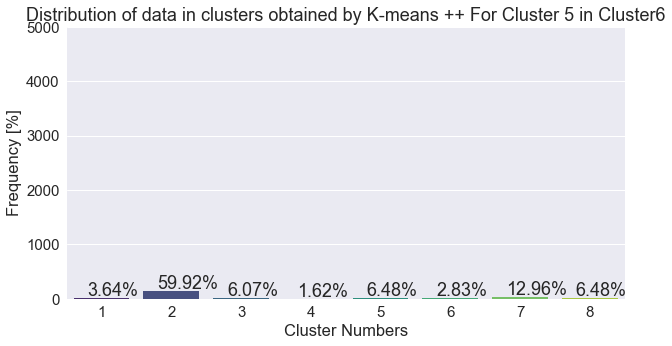

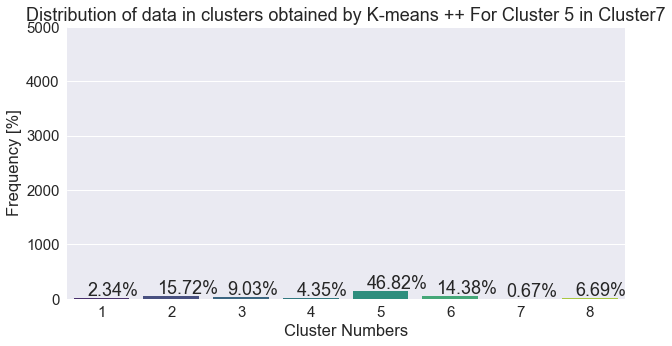

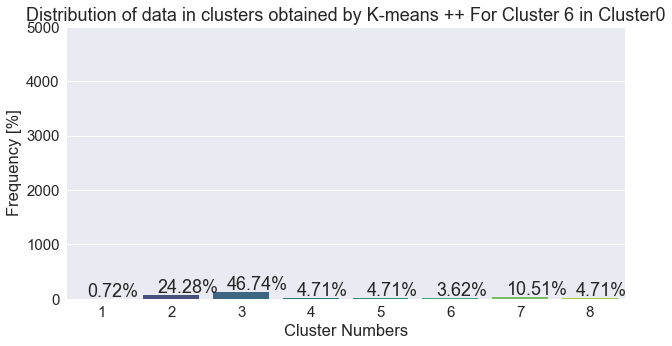

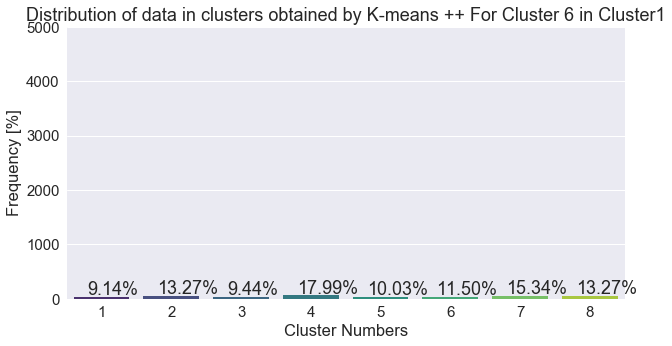

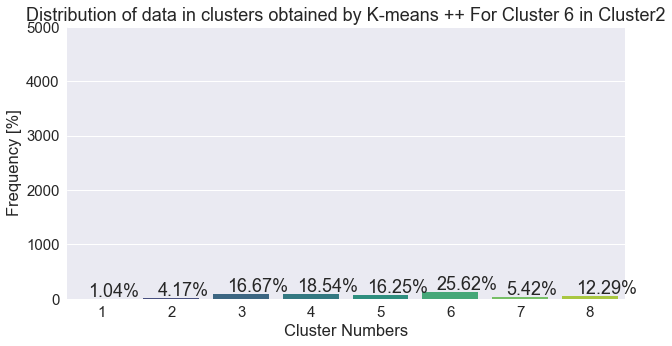

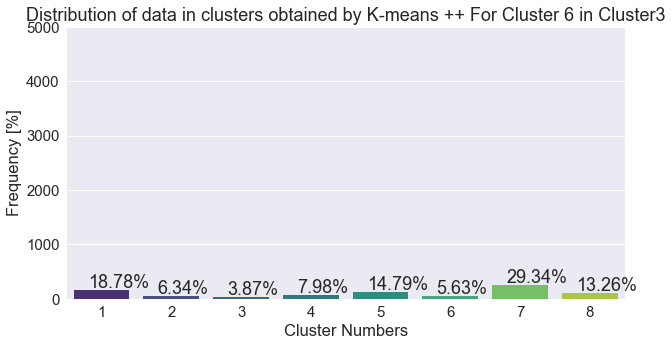

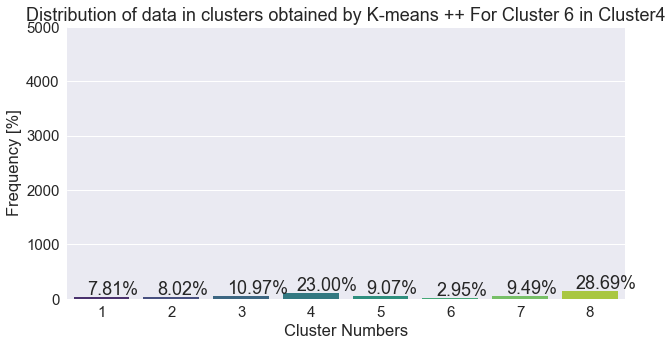

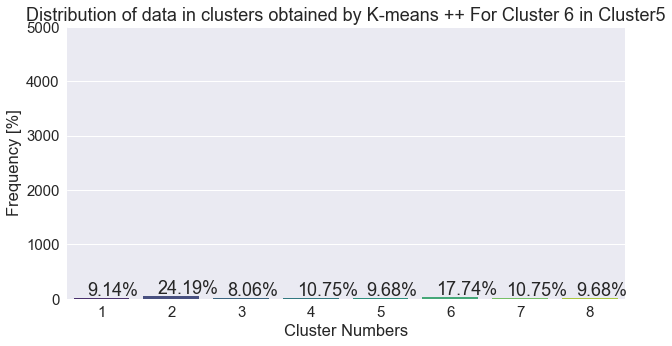

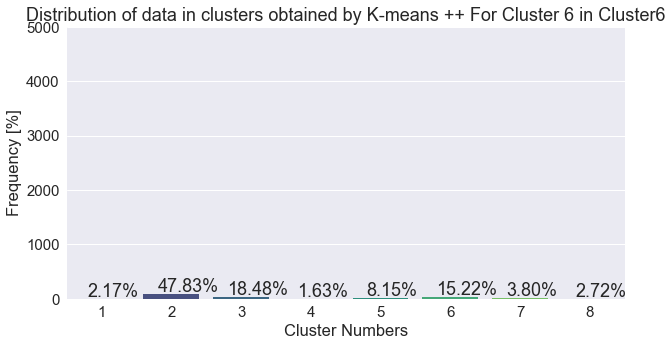

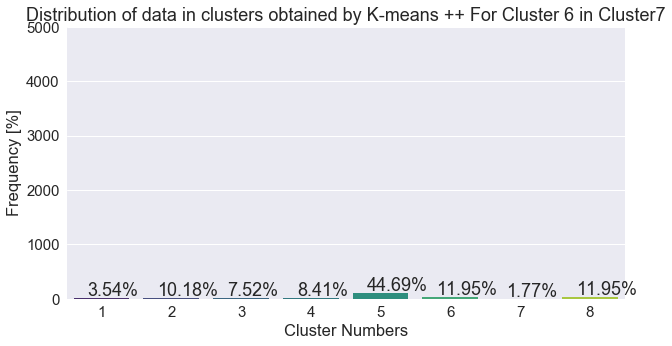

In [124]:
from sklearn.decomposition import PCA as sklearnPCA
import seaborn as sns
for i in range(len(kmeansSecondLevel)):
    ## Labels: Clusters 
    for j in range(len(childsList[i])):
    #     transformed = pd.DataFrame(pca.fit_transform(clusterValuesDFs[0][i]))
        labels = (kmeansSecondLevel[i]).fit_predict(childsList[i][j])
    #     y = np.array(kmeansSecondLevel[i].labels_)
        clusters = list(map(lambda x: x+1, labels))
        ## Distribution of data point in each of these clusters obtained by k-means ++ 

        ax = sns.countplot(x = clusters ,palette="viridis")
        sns.set(font_scale=1.5)
        ax.set_xlabel(' ')
        ax.set_ylabel(' ')
        fig = plt.gcf()
        fig.set_size_inches(10,5)
        ax.set_ylim(top=5000)
        for p in ax.patches:
            ax.annotate('{:.2f}%'.format(100*p.get_height()/len(clusters)), (p.get_x()+ 0.2, p.get_height()+ 40))

        plt.title('Distribution of data in clusters obtained by K-means ++ For Cluster '+str(i) + ' in Cluster ' + str(j) )
        plt.xlabel('Cluster Numbers')
        plt.ylabel('Frequency [%]')
        plt.show()
    

# Compare different clustering algorithms


## Before comparing let's show the amount of variance that each PC explains

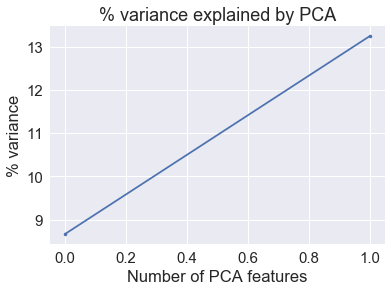

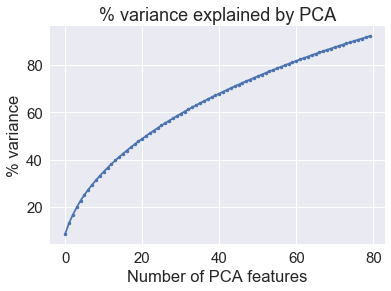

In [130]:
## PCA Analysis
df_pca,pca = pcaReduction(XFinal,2)
amountOfVariancePCA(pca)

df_pca,pca = pcaReduction(XFinal,80)
amountOfVariancePCA(pca)

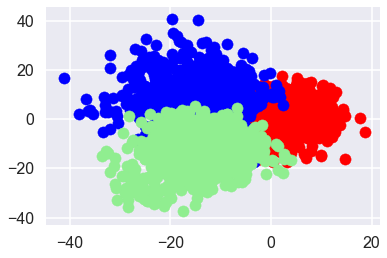

In [164]:
transformed,pca = pcaReduction(XFinal[:10000],2)
y = np.array(km.labels_[:10000])
plt.scatter(transformed[y==1][0], transformed[y==1][1], label='Class 1', c='red')
plt.scatter(transformed[y==2][0], transformed[y==2][1], label='Class 2', c='blue')
plt.scatter(transformed[y==3][0], transformed[y==3][1], label='Class 3', c='lightgreen')

# Interactive visualization

In [35]:
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="A map of word vectors",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

Loading BokehJS ...

In [36]:
def pcaVisualization(level,subLevel,desc):
#     importingLibrary()
    if desc!='leaf':
        word_vectors = list(child1[level])
        # dimensionality reduction. converting the vectors to 2d vectors
        from sklearn.manifold import TSNE
        tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
        tsne_w2v = tsne_model.fit_transform(word_vectors)

        # putting everything in a dataframe
        tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
        c = 'clustersValues'+str(level)
        tsne_df['words'] = list(VectorizedDf.loc[clustersValues[c]['Vector'].index.values,:]['NP'])
        
        # plotting. the corresponding word appears when you hover on the data point.
        plot_tfidf.scatter(x='x', y='y', source=tsne_df)
        hover = plot_tfidf.select(dict(type=HoverTool))
        hover.tooltips={"word": "@words"}
        show(plot_tfidf)
        
    else:
        word_vectors = list(clusterValuesDFs[level][subLevel]['Vector'])
        # dimensionality reduction. converting the vectors to 2d vectors
        from sklearn.manifold import TSNE
        tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
        tsne_w2v = tsne_model.fit_transform(word_vectors)

        # putting everything in a dataframe
        tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
        c = 'clustersValues'+str(level)
        tsne_df['words'] = list((clusterValuesDFs[level][subLevel]).iloc[:]['NP'])
        
        # plotting. the corresponding word appears when you hover on the data point.
        plot_tfidf.scatter(x='x', y='y', source=tsne_df)
        hover = plot_tfidf.select(dict(type=HoverTool))
        hover.tooltips={"word": "@words"}
        show(plot_tfidf)        
    return

In [38]:
pcaVisualization(0,1,'leaf')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 658 samples in 0.004s...
[t-SNE] Computed neighbors for 658 samples in 0.111s...
[t-SNE] Computed conditional probabilities for sample 658 / 658
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.627403
[t-SNE] Error after 1000 iterations: 1.164763


# Visualize first 10000 token vectors

In [175]:
import sklearn.manifold
from sklearn.manifold import TSNE
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
word_vectors_matrix_2d = tsne.fit_transform(XFinal[:10000])
print("word_vectors_matrix_2d shape is ", word_vectors_matrix_2d.shape)
import pandas as pd
points = pd.DataFrame(
    [
        (word, coords[0], coords[1]) 
        for word, coords in [
            (word, word_vectors_matrix_2d[list(word2VecModel.wv.vocab.keys())[:10000].index(word)])
            for word in list(word2VecModel.wv.vocab.keys())[:10000]
        ]
    ],
    columns=["word", "x", "y"]
)
print("Points DataFrame built")

word_vectors_matrix_2d shape is  (10000, 2)
Points DataFrame built


In [180]:
points[10:15]

word          x          y
10     عطرة -18.242260 -62.613464
11  الاوراق  -7.751276  -8.732345
12    داءمة -10.765979  29.866688
13   الخضرة  14.284409  20.624554
14    يعتبر  47.538651  -6.295451

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context("poster")

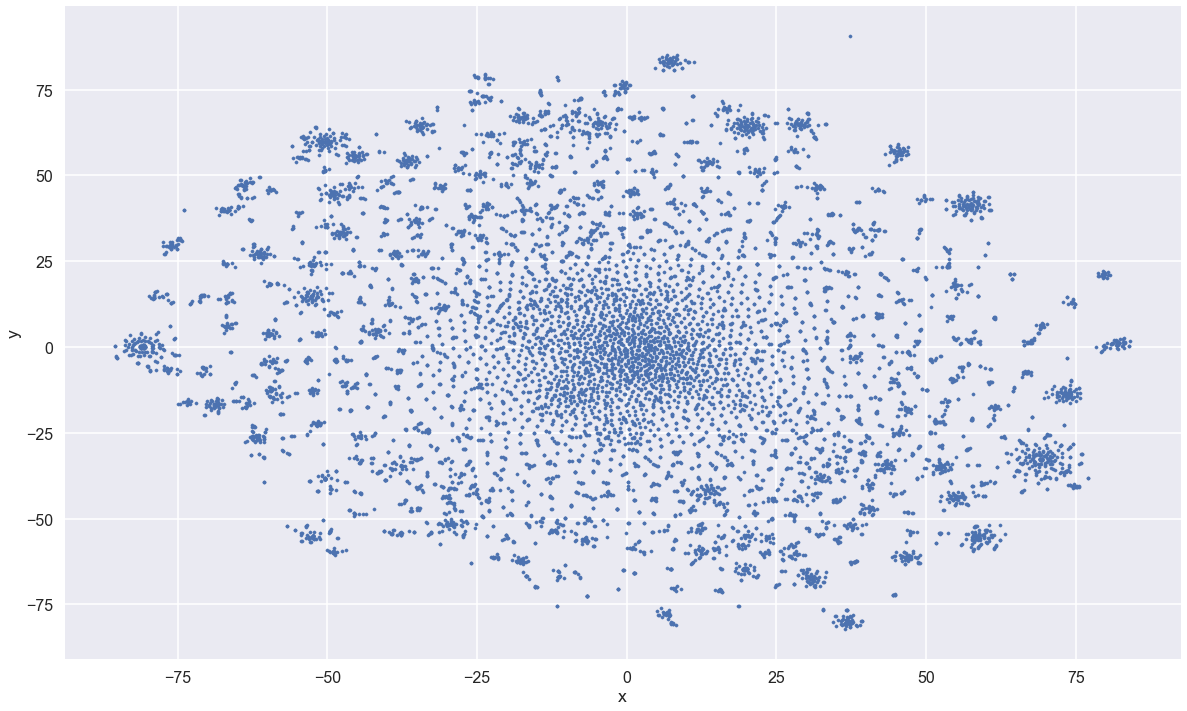

In [182]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

# Get centers of leaves clusters

In [39]:
def getCentersNeighbors(childsList,kmeansSecondLevel,clusterValuesDFs,vecSize):
    from sklearn.metrics.pairwise import euclidean_distances, pairwise_distances
    # euclidean_distances(X, estimators[0][1].cluster_centers_).shape
    centersList = []
    for i in range(len(childsList)):
        local = []
        for j in range(len(childsList[i])):
            p = pairwise_distances(childsList[i][j], (kmeansSecondLevel[i].cluster_centers_[j]).reshape((1,vecSize))).T[0]
#                 print(p.shape)
#                 print(p.argsort()[:10])
            h = p.argsort()[:50]
            local.append(list((clusterValuesDFs[i][j]).iloc[h]['NP']))
        centersList.append(local)
#         centersList.append(local)
        
    return centersList

In [40]:
centerList = getCentersNeighbors(childsList,kmeansSecondLevel,clusterValuesDFs,word2VecModel.wv.vector_size)
print(centerList[0][0][:10])
print(len(centerList[0][0]))

['نبات الخطمية', 'رينودز نبات الخردلة', 'نبات المفلوف', 'نبات الحصاالبان', 'نبات اللقت', 'نبات الرعد', 'نبات طفيلي', 'نبات المانيوك', 'نبات النديم', 'نبات الرواند']
50


# Taxonomical relationships extraction
## Tagging Corpus to apply regex

In [41]:
def importPosTagger():
    import nltk
    import os
    from nltk.tag import StanfordPOSTagger
    java_path = "C:/Program Files/Java/jdk1.8.0_25/bin/java.exe"
    os.environ['JAVAHOME'] = java_path
    nltk.internals.config_java("C:/Program Files/Java/jdk1.8.0_121/bin/java.exe")
    jar = 'C:/Users/rashed/Desktop/tools/stanford-postagger-full-2017-06-09/stanford-postagger.jar'
    model = 'C:/Users/rashed/Desktop/tools/stanford-postagger-full-2017-06-09/models/arabic.tagger'
    return StanfordPOSTagger(model, jar, encoding='utf8')

filePath = "AllSentences.0.2\\2"
sentencesForTagging = loadSentences(filePath)

pos_tagger = importPosTagger() # without trailing slashes \
sents = pos_tagger.tag_sents([nltk.wordpunct_tokenize(sent) for sent in sentencesForTagging])
taggedSents = [[token[1].replace("/", "|") for token in sent] for sent in sents]

In [462]:
pair = []
pair.append('يحتوي')
pair.append('علي')
k = 'كمية'
kk = 'كبيرة'
m = 'من'

listOfPtrs = []
listOfHypo = []
ptrnRegex = re.compile(r"(?P<pattern>([\u0621-\u063A\u0641-\u064A]+\|[A-Z]+\s*){1,2}"+pair[0]+"\|[A-Z]+\s+[\u0621-\u063A\u0641-\u064A]+\|(DTNN)\s*"+pair[1]+"\|[A-Z]+\s(كمية\|[A-Z]+ +(كبيرة\|[A-Z]+ +)?من\|[A-Z]+ +)?(?P<Hyponym>[\u0621-\u063A\u0641-\u064A]+\|[^WCB ]+ *){1,3})")
for i in taggedSents:
        m = ptrnRegex.search(' '.join(i))
        if m is not None:
            print(m.group('pattern'))
            listOfPtrs.append(m.group('pattern'))

فوائد|NN الكرفس|DTNN يحتوي|VBP الكرفس|DTNN علي|IN حوالي|NOUN 
حيث|WRB يحتوي|VBP الكرفس|DTNN علي|IN البثاليدز|DTNN النشطة|DTJJ 
العظام|DTNN والانسجه|NN يحتوي|VBP الزيتون|DTNN علي|IN فيتامين|NNP 
الكولسترول|DTNN وكذلك|NN يحتوي|VBP البرتقال|DTNN علي|IN فيتامين|NNP ج|NN 
يفضل|VBP الا|RP يحتوي|VBP السحور|DTNN علي|IN كمية|NN كبيرة|JJ من|IN السكر|DTNN 
الماء|DTNN وايضا|NN يحتوي|VBP البطيخ|DTNN علي|IN الماغنسيوم|DTNN 
الوزن|DTNN وايضا|NNP يحتوي|VBP الرومان|DTNN علي|IN فيتامين|NNP سي|NN 
يجب|VBP ان|IN يحتوي|VBP الغذاء|DTNN علي|IN الياف|NN ولهذا|NN ينصح|V
يجب|VBP ان|IN يحتوي|VBP الفطار|DTNN علي|IN طبق|NN السلطة|DTNN اللذيذ|DTJJ 
علميا|NN باسم|NNP يحتوي|VBP النبات|DTNN علي|IN مواد|NN عفصية|JJ وجلوكوزيدات|NNS 
بمرض|NN السكر|DTNN يحتوي|VBP التفاح|DTNN علي|IN مواد|NN مضاده|NN للاكسده|NNP 
و|CC قد|RP يحتوي|VBP البول|DTNN علي|IN صديد|NN 
الغذاءية|DTJJ كما|CC يحتوي|VBP الخيار|DTNN علي|IN فيتامين|NNP ج|NN المضاد|DTJJ 
ودواء|JJ حيث|WRB يحتوي|VBP العسل|DTNN علي|IN عناصر|NN غذاءية|JJ هامة|JJ 
ساعة|NN اذ|IN

Load conll-tagged Senteces

In [42]:
import codecs
centerList

fileName = r"AllSentences.0.2\44200[wellprocessed][NPs][conll]"
with codecs.open(fileName, "r", "utf-8") as f:
    conllSents = [line.strip() for line in f]

In [187]:
word2VecModel.wv.most_similar('البرتقال')

[('الليمون', 0.7287262082099915),
 ('الموز', 0.679776668548584),
 ('الجزر', 0.6085215210914612),
 ('الرمان', 0.5928706526756287),
 ('الافوكادو', 0.5821214318275452),
 ('البطيخ', 0.5798993706703186),
 ('برتقال', 0.5727777481079102),
 ('الخوخ', 0.5696399807929993),
 ('المشمش', 0.5626479387283325),
 ('التفاح', 0.5548925995826721)]

In [43]:
relation = []
relation.append('يحتوي')
relation.append('علي')

# relation = []
# relation.append('هو')

listOfPtrs = []
listOfHypo = []

In [46]:
r"(?P<pattern>"+relation[0]+" +"+pair1[0]+" +"+relation[1]+" +"+pair1[1]+")"
from string import punctuation

print(pair1[0])
print(pair1[1])
pair1[0].strip(punctuation+" ")

دهون البلازمة
NP\[(?P<pair1>[ء-غف-ي ]+)\]


'دهون البلازمة'

In [47]:
listOfPtrs = []
for i in range(len(centerList)):
    for j in range(len(centerList[i])):
        for np in centerList[i][j]:
            pair1 = (
                np,
                "NP\[(?P<pair1>[\u0621-\u063A\u0641-\u064A ]+)\]"
            )
            pair2 = (
                "NP\[(?P<pair2>[\u0621-\u063A\u0641-\u064A ]+)\]",
                np
            )
            try:
                ptrnRegex1 = re.compile(r"(?P<pattern>"+relation[0]+" +NP\["+pair1[0].strip(punctuation+" ")+"\] +"+relation[1]+" +"+pair1[1]+")")
#                 ptrnRegex1 = re.compile(r"(?P<pattern> +NP\["+pair1[0].strip(punctuation+" ")+"\] +"+relation[0]+" +"+pair1[1]+")")
#                 ptrnRegex2 = re.compile(r"(?P<pattern>"+relation[0]+" +"+pair2[0]+" +"+relation[1]+" +NP\["+pair2[1].strip(punctuation+" ")+"\])")
                ptrnRegex = ptrnRegex1
                for sent in conllSents:
                        m = ptrnRegex.search(sent)
                        if m is not None:
#                             print("cluster %d from cluster %d" % (j, i) )
#                             print(m.group('pattern'))
                            listOfPtrs.append(((pair1[0], ((i, j))), m.group('pair1')))
#                 ptrnRegex = ptrnRegex2
#                 for sent in conllSents:
#                         m = ptrnRegex.search(sent)
#                         if m is not None:
#                             listOfPtrs.append((m.group('pair2')), (pair2[1], ((i, j))))
            except:
                print("Error occured")
                

print(len(listOfPtrs))
listOfPtrs

26


[(('نبات الخلنج', (0, 0)), 'الاربوتين'),
 (('نبات الاترنج', (0, 0)), 'الليمونين'),
 (('نبات الخس', (0, 0)), 'فيتامين ا'),
 (('القرنفل', (0, 2)), 'الالياف'),
 (('الزعتر', (0, 7)), 'زيت طيار'),
 (('البابونج', (0, 7)), 'مضادات الاكسدة'),
 (('البابونج', (0, 7)), 'الزيوت الطيارة'),
 (('البابونج', (0, 7)), 'مواد مضادة للاكسدة'),
 (('النعناع', (0, 7)), 'زيت طيار'),
 (('العرعر', (0, 7)), 'زيت طيار'),
 (('قشر البرتقال', (5, 0)), 'فيتامين ج'),
 (('خل التفاح', (5, 1)), 'حمض الخليك'),
 (('الزبيب', (5, 3)), 'البوتاسيوم'),
 (('الزبادي', (5, 3)), 'حمض اللاكتيك'),
 (('العسل', (5, 4)), 'المواد'),
 (('العسل', (5, 4)), 'حمض النيكوتنيك'),
 (('العسل', (5, 4)), 'الفيتامينات'),
 (('الكمون', (5, 4)), 'فيتامين ه'),
 ((':, الزنجبيل', (5, 5)), 'مضادات الاكسدة'),
 ((':, الزنجبيل', (5, 5)), 'الفيتامينات'),
 (('الزنجبيل', (5, 5)), 'مضادات الاكسدة'),
 (('الزنجبيل', (5, 5)), 'الفيتامينات'),
 (('الشاي', (5, 5)), 'حامض التانيك'),
 (('الكركديه', (5, 5)), 'الفلافونيدات'),
 (('لبن المخيض', (5, 7)), 'حمض اللاكتيك'),
 (('ال

In [173]:
def getClusterNumberofVec(kalsium,vecSize):
    '''
    return :
        tuple(modelNumber, clusterNumber)
    '''
    from sklearn.metrics.pairwise import euclidean_distances, pairwise_distances

    for i in range(len(kmeansSecondLevel)):
        p = pairwise_distances(kalsium[1].reshape((1,vecSize)), kmeansSecondLevel[i].cluster_centers_)[0]
    #     print(p)
        h = p.argsort()[0]
    #     print(h)
        if i == 0:
            minimun = p[h]
            clusterIdx = i
            minIdx = h
        else:
            if minimun > p[h]:
                minimun = p[h]
                clusterIdx = i
                minIdx = h
    return tuple((clusterIdx, minIdx))
# tempVector = word2VecModel.wv.get_vector('الكالسيوم')
# print(getClusterNumberofVec(tempVector,word2VecModel.wv.vector_size))

In [52]:
import numpy as np
listOfRelationedPairs = []
for tup in listOfPtrs:
    NP = tup[1]
    vectorNp = (NP, computeVectorFromRaw(NP, word2VecModel))
    if type(vectorNp[1]) == np.ndarray:
        clusterCluster = getClusterNumberofVec(vectorNp,vecSize=word2VecModel.wv.vector_size)
        pairWithCluster = (tup[0], (tup[1], clusterCluster))
        listOfRelationedPairs.append(pairWithCluster)

print(len(listOfRelationedPairs))
listOfRelationedPairs

25


[(('نبات الاترنج', (0, 0)), ('الليمونين', (4, 4))),
 (('نبات الخس', (0, 0)), ('فيتامين ا', (6, 6))),
 (('القرنفل', (0, 2)), ('الالياف', (6, 3))),
 (('الزعتر', (0, 7)), ('زيت طيار', (0, 1))),
 (('البابونج', (0, 7)), ('مضادات الاكسدة', (6, 5))),
 (('البابونج', (0, 7)), ('الزيوت الطيارة', (6, 4))),
 (('البابونج', (0, 7)), ('مواد مضادة للاكسدة', (6, 5))),
 (('النعناع', (0, 7)), ('زيت طيار', (0, 1))),
 (('العرعر', (0, 7)), ('زيت طيار', (0, 1))),
 (('قشر البرتقال', (5, 0)), ('فيتامين ج', (6, 6))),
 (('خل التفاح', (5, 1)), ('حمض الخليك', (6, 0))),
 (('الزبيب', (5, 3)), ('البوتاسيوم', (6, 3))),
 (('الزبادي', (5, 3)), ('حمض اللاكتيك', (6, 0))),
 (('العسل', (5, 4)), ('المواد', (6, 4))),
 (('العسل', (5, 4)), ('حمض النيكوتنيك', (6, 0))),
 (('العسل', (5, 4)), ('الفيتامينات', (6, 1))),
 (('الكمون', (5, 4)), ('فيتامين ه', (6, 6))),
 ((':, الزنجبيل', (5, 5)), ('مضادات الاكسدة', (6, 5))),
 ((':, الزنجبيل', (5, 5)), ('الفيتامينات', (6, 1))),
 (('الزنجبيل', (5, 5)), ('مضادات الاكسدة', (6, 5))),
 (('الزنج

In [58]:
from sklearn.metrics.pairwise import euclidean_distances
from scipy import spatial

In [59]:
# listOfVocabVec = list(word2VecModel.wv.vectors)
zaatar = word2VecModel.wv.get_vector('الاشوجندا')
def getMostSimilar(clusterValuesDFs,vector,n):
    from sklearn.metrics.pairwise import euclidean_distances
    from scipy import spatial
    vector = vector.reshape((100,1))
    for k in range(len(clusterValuesDFs)):
        for l in range(len(clusterValuesDFs[k])):
            distances = []
            for i in range(len(clusterValuesDFs[k][l])):
                clusterVector = clusterValuesDFs[k][l].iloc[i]['Vector']
                nounPhrase = clusterValuesDFs[k][l].iloc[i]['NP']
                clusterVector = clusterVector.reshape((100,1))
                distance = 1 - spatial.distance.cosine(vector.T,clusterVector.T)
#                 distance = euclidean_distances(clusterVector.T,vector.T)
                distances.append((distance,nounPhrase))
    distances.sort(key=lambda x:x[0])
    return distances
li = getMostSimilar(clusterValuesDFs,zaatar,50)

In [61]:
li[-10:]

[(0.068673018660617702, 'هضم الدهنيات الثلاثية'),
 (0.078672585646305193, 'للدهون الجيدة'),
 (0.084197564516700352, 'وتفرز السواءل'),
 (0.10634891268120983, 'فضلات الغذاء'),
 (0.10736420775743616, 'الدهنيات الثلاثية'),
 (0.10926722908505671, 'دهون الفستق الحلبي'),
 (0.10976855857390755, 'اكسدة الطعام'),
 (0.14752853824727874, 'السواءل بكميات كافية'),
 (0.15164424427861023, 'الدهون الاعشاب المقوية'),
 (0.1891974033872259, 'السواءل الداخلة للجسم')]

In [55]:
word2VecModel.wv.most_similar('العبعب')

[('الاشوجندا', 0.5215427279472351),
 ('الجنكا', 0.4509275257587433),
 ('الخرفيش', 0.42543792724609375),
 ('القبار', 0.4134935736656189),
 ('المورينجا', 0.41186726093292236),
 ('الحيطة', 0.40694165229797363),
 ('البردقوس', 0.40236037969589233),
 ('ورمان', 0.39668917655944824),
 ('الخلة', 0.3881768584251404),
 ('كابول', 0.3847215175628662)]

In [62]:
w = 'الخلايا'
v = computeVectorFromRaw(w,word2VecModel)
t = (w,v)
t = getClusterNumberofVec(t,word2VecModel.wv.vector_size)

def getMostSimilar(cluster,vector,n):
    vector = vector.reshape((100,1))
    distances = []
    for i in range(len(cluster)):
        clusterVector = cluster.iloc[i]['Vector']
        nounPhrase = cluster.iloc[i]['NP']
        clusterVector = clusterVector.reshape((100,1))
        distance = 1 - spatial.distance.cosine(vector.T,clusterVector.T)
#                 distance = euclidean_distances(clusterVector.T,vector.T)
        distances.append((distance,nounPhrase))
    distances.sort(key=lambda x:-x[0])
    return distances
li = getMostSimilar(clusterValuesDFs[t[0]][t[1]],v,50)

In [63]:
li[:50]

[(1.0000000478497635, 'الخلايا المناعيه'),
 (1.0000000478497635, 'لانقسام الخلايا'),
 (1.0000000478497635, 'الخلايا المنجلية'),
 (1.0000000478497635, 'الخلايا'),
 (1.0000000478497635, 'الخلايا المخلقه'),
 (1.0000000478497635, 'الخلايا الصباغية'),
 (1.0000000478497635, 'الخلايا الكراتنية'),
 (1.0000000478497635, 'الخلايا الكراتينيه'),
 (1.0000000478497635, 'الخلايا من الطور'),
 (1.0000000478497635, 'الخلايا المتضخمة'),
 (1.0000000478497635, 'الخلايا البصرية'),
 (1.0000000478497635, 'الخلايا الاستقبالية'),
 (1.0000000478497635, 'مقارنتها مع الخلايا'),
 (1.0000000478497635, 'الخلايا الموودة'),
 (1.0000000478497635, 'الخلايا المنبتية'),
 (1.0000000478497635, 'ترليونات الخلايا'),
 (1.0000000478497635, 'لتمحور الخلايا'),
 (1.0000000478497635, 'الخلايا الصباغيه'),
 (1.0000000478497635, 'جدارا لصد الخلايا'),
 (1.0000000478497635, 'الخلايا الدخليه'),
 (0.93504800960709555, 'بتاكسد الخلايا'),
 (0.92905133835245202, 'الخلايا المستمدة'),
 (0.92245566007309721, 'الخلايا المفرزة'),
 (0.9141421273857

In [86]:
w1 = 'الخلايا الحمراء'
vec = computeVectorFromRaw(w1,word2VecModel)
isAoffset = v - vec
t = getClusterNumberofVec((w1,vec),word2VecModel.wv.vector_size)
idx0 = 0
for i in childsList[t[0]][t[1]]:
    idx = 0
    for j in childsList[t[0]][t[1]]:
#         if (i != j).all():
        off = i - j
#             sub = isAoffset - off
#             mag = sub.dot(sub)
#             mag = np.sqrt(mag)
#             idx = idx +1
        asd= np.linalg.norm(off)
        if asd < 0.001:
            print(idx,' ', idx0)
    idx0 = idx0+1
#                 print(asd)

0   0
0   1
0   2
0   2
0   2
0   2
0   2
0   2
0   2
0   2
0   2
0   2
0   2
0   2
0   2
0   2
0   2
0   2
0   2
0   2
0   2
0   2
0   3
0   4
0   5
0   6
0   6
0   6
0   6
0   6
0   6
0   6
0   6
0   6
0   6
0   6
0   6
0   6
0   6
0   6
0   6
0   6
0   6
0   6
0   6
0   7
0   8
0   9
0   10
0   11
0   12
0   13
0   14
0   15
0   16
0   16
0   17
0   18
0   19
0   20
0   21
0   22
0   23
0   24
0   24
0   24
0   24
0   24
0   24
0   24
0   24
0   24
0   24
0   24
0   24
0   24
0   24
0   24
0   24
0   24
0   24
0   24
0   24
0   25
0   26
0   27
0   28
0   29
0   30
0   31
0   32
0   33
0   34
0   35
0   36
0   37
0   38
0   39
0   40
0   41
0   42
0   43
0   44
0   45
0   45
0   45
0   45
0   45
0   45
0   45
0   45
0   45
0   45
0   45
0   45
0   45
0   45
0   45
0   45
0   45
0   45
0   45
0   45
0   46
0   47
0   47
0   47
0   47
0   47
0   47
0   47
0   47
0   47
0   47
0   47
0   47
0   47
0   47
0   47
0   47
0   47
0   47
0   47
0   47
0   48
0   49
0   50
0   51
0   52
0   5

In [98]:
print(clusterValuesDFs[t[0]][t[1]].iloc[0]['NP'])
print(clusterValuesDFs[t[0]][t[1]].iloc[250]['NP'])

خلايا العظم
خلايا نخاع العظام
